In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

from Oceanmodel.policy_ve import *
from Oceanmodel.stateupdates_ve import *
from Oceanmodel.engine import *


In [2]:
MONTE_CARLO_RUNS = 1
sim_length = 832 #CHANGE IN behavior_ve.py too!!!

In [3]:
# Simulation 1
sim_config = config_sim({
    "N": MONTE_CARLO_RUNS,
    "T": range(sim_length),
    "M": system_params
})

psubs = generate_psubs()

for i in range(len(psubs)):
    experiment.append_configs(
        initial_state = initial_state,
        partial_state_update_blocks = psubs[i],
        sim_configs = sim_config
    )

#experiment.append_configs(
#    initial_state = initial_state,
#    partial_state_update_blocks = psubs[10],
#    sim_configs = sim_config
#)

psub assumptions: Locking: p_lock_1, Voting: p_vote_1, Consumption: p_data_asset_consumed_1
psub assumptions: Locking: p_lock_1, Voting: p_vote_1, Consumption: p_data_asset_consumed_2
psub assumptions: Locking: p_lock_1, Voting: p_vote_1, Consumption: p_data_asset_consumed_3
psub assumptions: Locking: p_lock_1, Voting: p_vote_2, Consumption: p_data_asset_consumed_1
psub assumptions: Locking: p_lock_1, Voting: p_vote_2, Consumption: p_data_asset_consumed_2
psub assumptions: Locking: p_lock_1, Voting: p_vote_2, Consumption: p_data_asset_consumed_3
psub assumptions: Locking: p_lock_2, Voting: p_vote_3, Consumption: p_data_asset_consumed_1
psub assumptions: Locking: p_lock_2, Voting: p_vote_3, Consumption: p_data_asset_consumed_2
psub assumptions: Locking: p_lock_2, Voting: p_vote_3, Consumption: p_data_asset_consumed_3
psub assumptions: Locking: p_lock_2, Voting: p_vote_4, Consumption: p_data_asset_consumed_1
psub assumptions: Locking: p_lock_2, Voting: p_vote_4, Consumption: p_data_asset

In [4]:
## Simulation 3
#sim_config = config_sim({
#    "N": MONTE_CARLO_RUNS,
#    "T": range(sim_length),
#    "M": system_params
#})
#
#experiment.append_configs(
#    initial_state = initial_state,
#    partial_state_update_blocks = partial_state_update_blocks_behaviors_C,
#    sim_configs = sim_config
#)

In [5]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)

raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 12
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (832, 13, 1, 10)
Execution Method: local_simulations
SimIDs   : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ExpIDs   : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Execution Mode: parallelized
Total execution time: 516.58s


In [6]:
# Get df
simulation_result = pd.DataFrame(raw_result)

In [7]:
simulation_result.groupby(['simulation', 'run']).count()['timestep']

simulation  run
0           1      3329
1           1      3329
2           1      3329
3           1      3329
4           1      3329
5           1      3329
6           1      3329
7           1      3329
8           1      3329
9           1      3329
10          1      3329
11          1      3329
Name: timestep, dtype: int64

In [8]:
# Analysis and plotting modules
import pandas as pd
import numpy as np
# import plotly
import matplotlib.pyplot as plt

In [9]:
# df for monte carlo plots
last_substep = max(simulation_result.substep)

df_p = simulation_result.copy()
df_p = df_p[df_p.substep == last_substep]
df_p['ve_balance'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].vebalance for acct in x['ve_accounts'].keys()]), axis=1)
df_p['locked_supply'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].locked for acct in x['ve_accounts'].keys()]), axis=1)
#df_p['lock_duration_sum'] = df_p.groupby('run').apply(lambda x: sum([x['ve_accounts'][acct].lockduration for acct in x['ve_accounts'].keys()]), axis=1)
#df_p['lock_duration_diff'] = df_p.groupby('run').diff()['lock_duration_sum']
df_p['active_pct'] = df_p.apply(lambda x: sum([x['votes'][asset] for asset in x['votes'].keys()]), axis=1)
df_p['pct_locked'] = df_p['locked_supply'] / (df_p['locked_supply'] + df_p['ocean_unlocked_supply'])
df_p['dcv'] = df_p.apply(lambda x: sum([x['data_assets'][asset].dataconsumevolume for asset in x['data_assets'].keys()]), axis=1)
df_p['Passive_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_p['Active_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['locked_supply'])) ** 52 - 1 if x['locked_supply'] != 0 and x['active_pct'] != 0 else 0, axis=1)
df_p['Fees_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_fees']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
#df_p['Agg_APY'] = df_p.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
#df_p['Agg_APY'] = df_p.apply(lambda x: ((1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1) + x['Active_APY']*x['active_pct'] if x['locked_supply'] != 0 else 0, axis=1)
df_p['Agg_APY'] = df_p.apply(lambda x: (x['Passive_APY'] + x['Fees_APY'] + x['Active_APY']*x['active_pct']), axis=1)


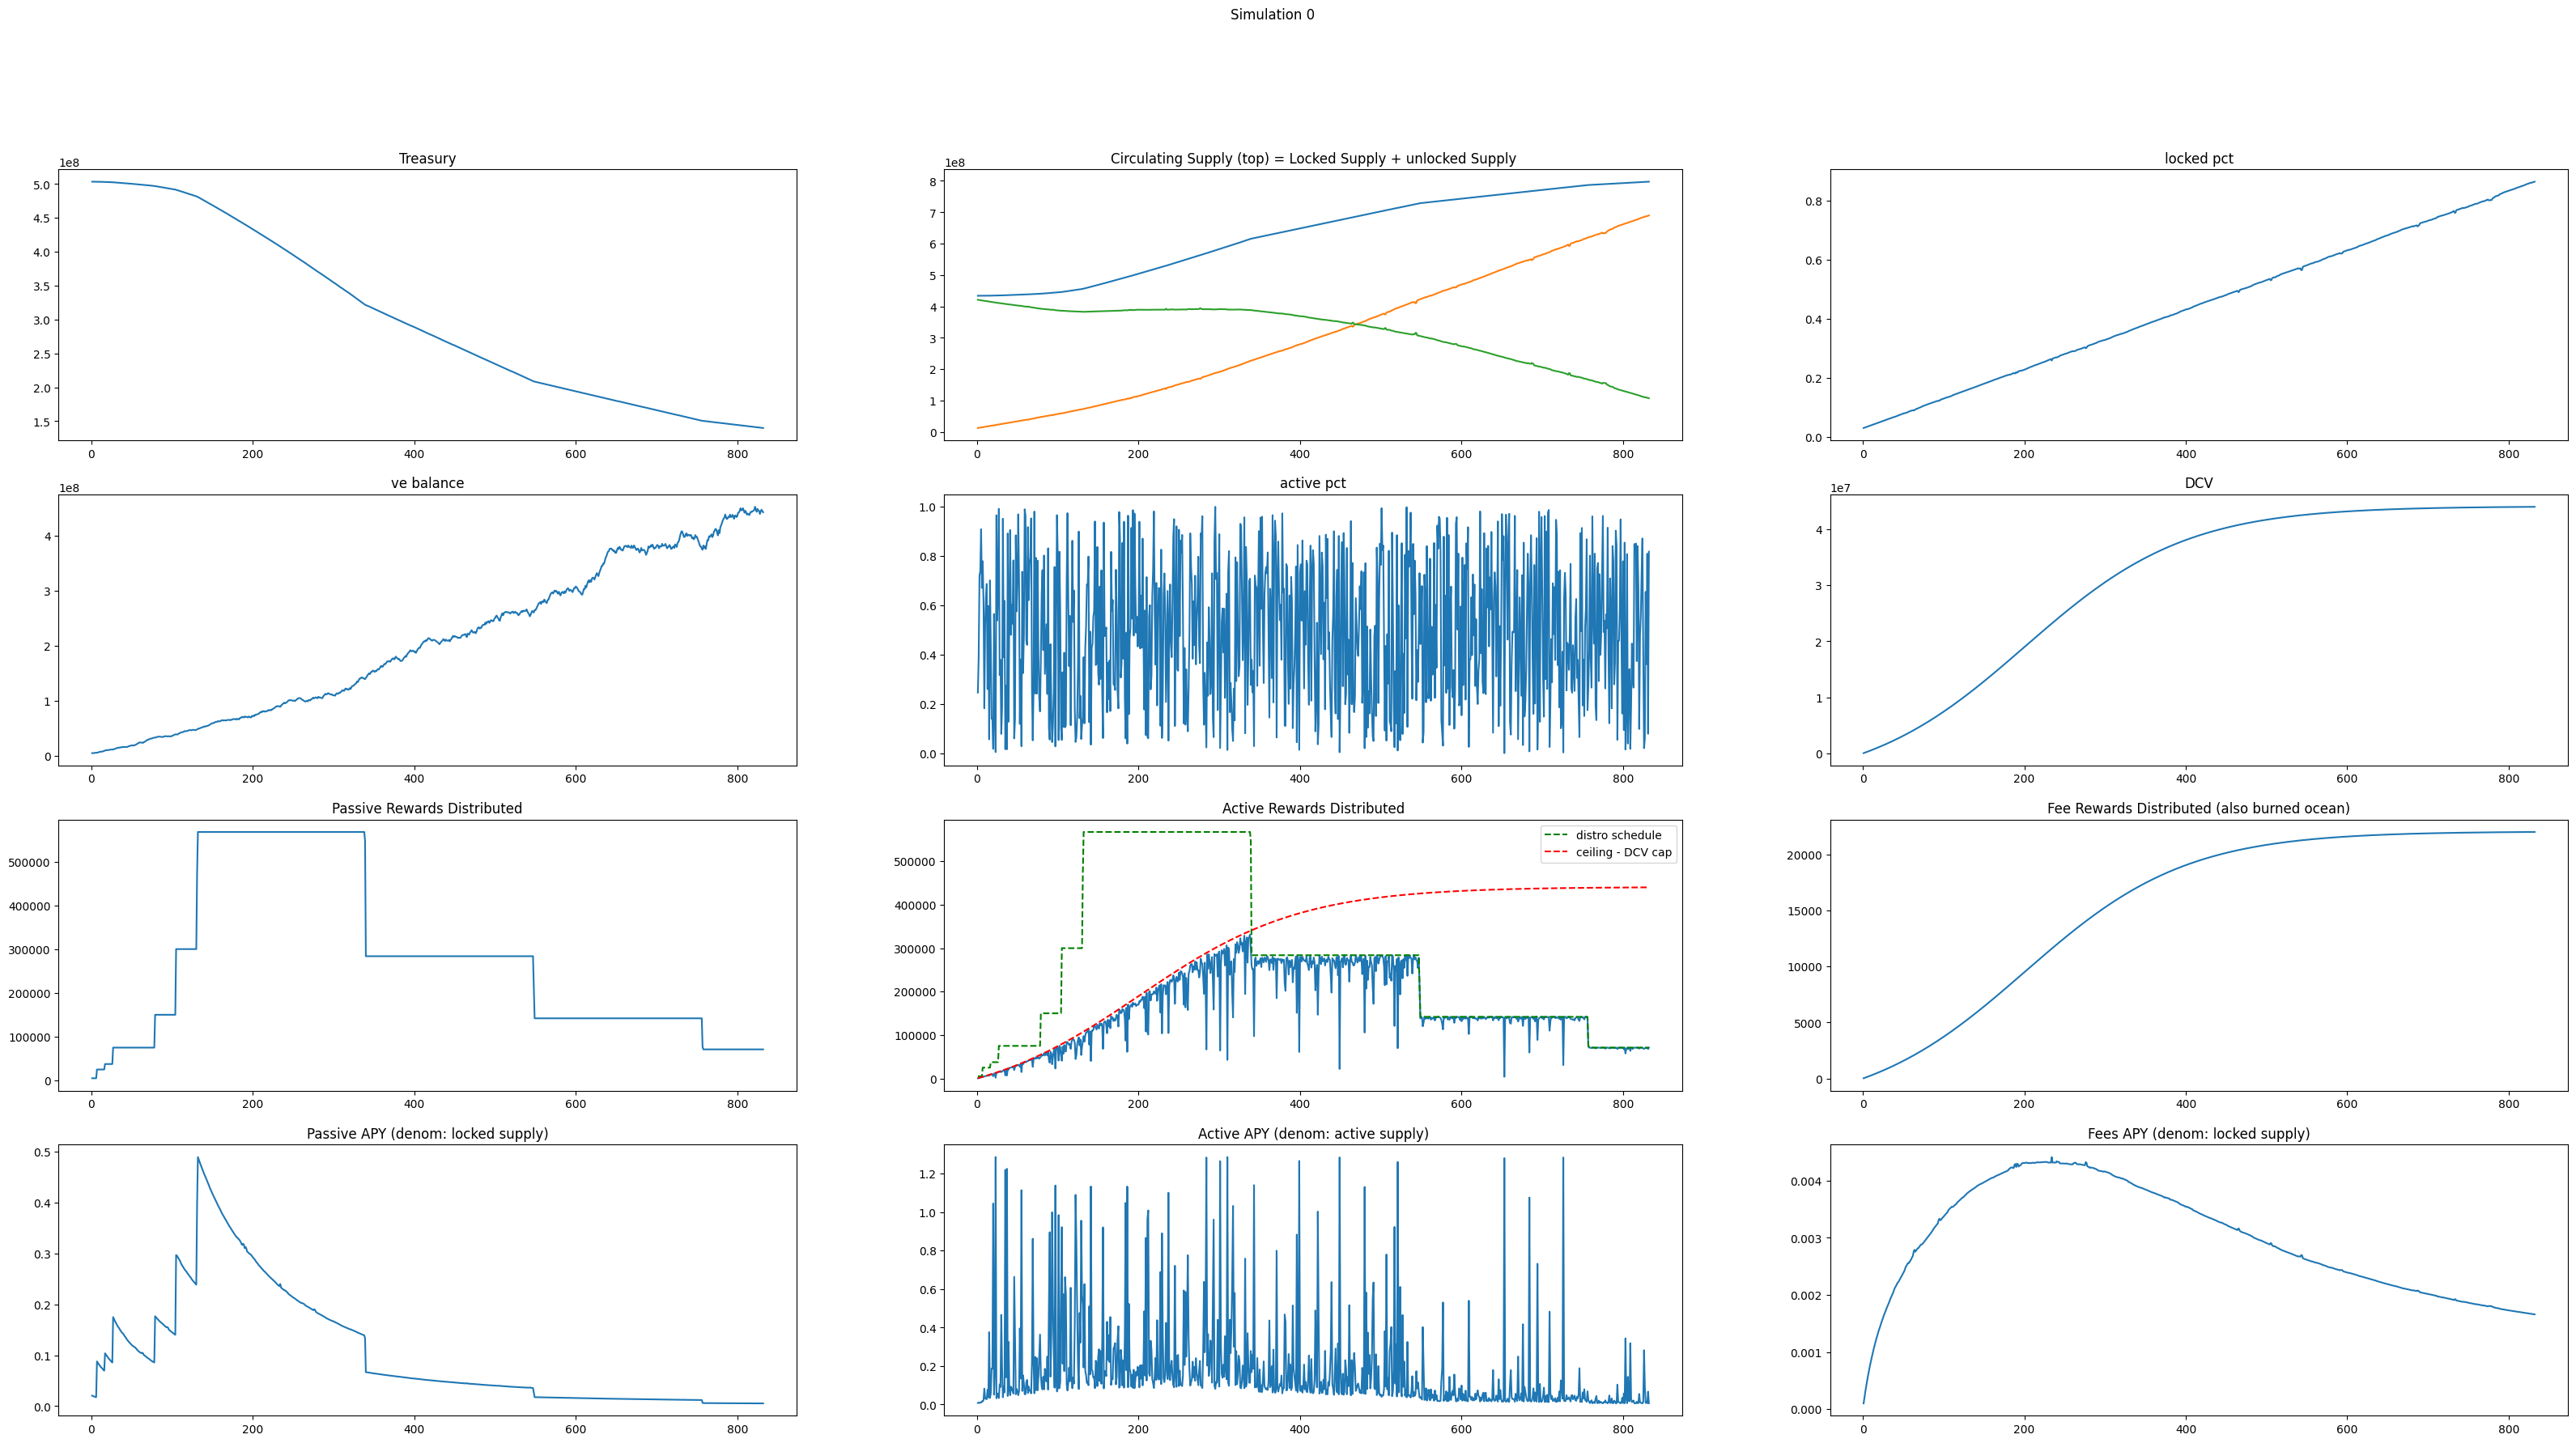

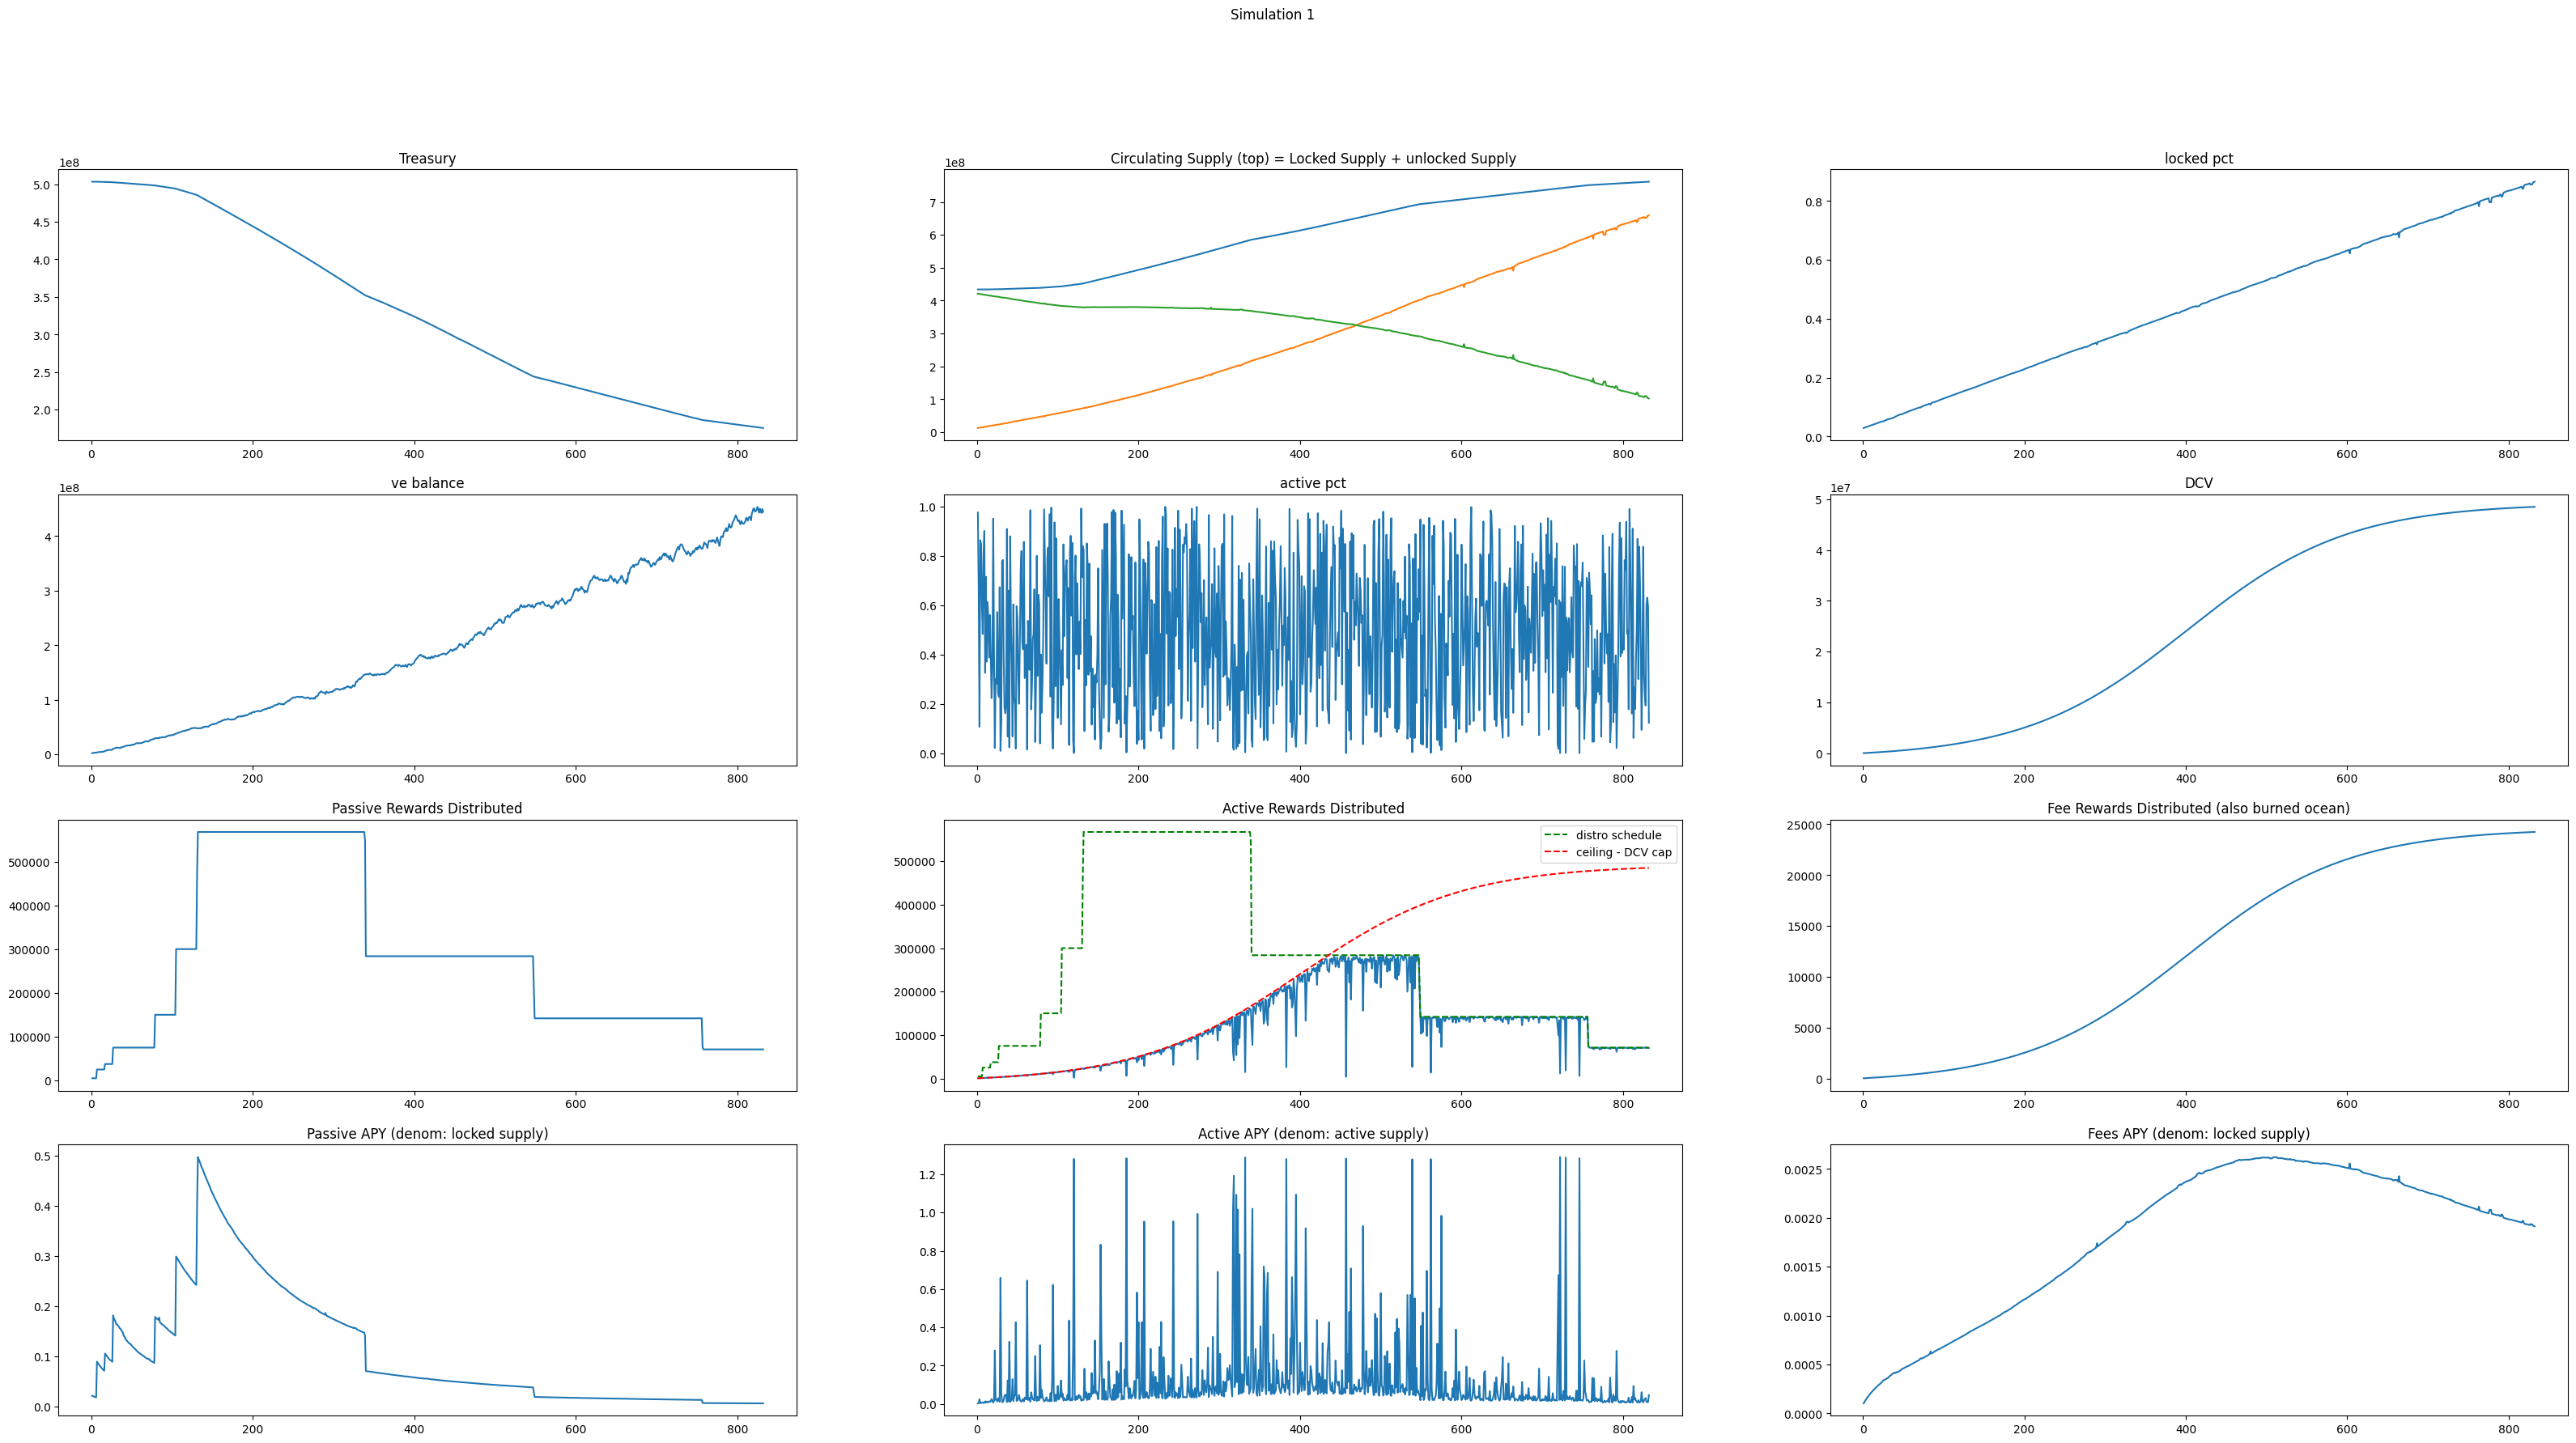

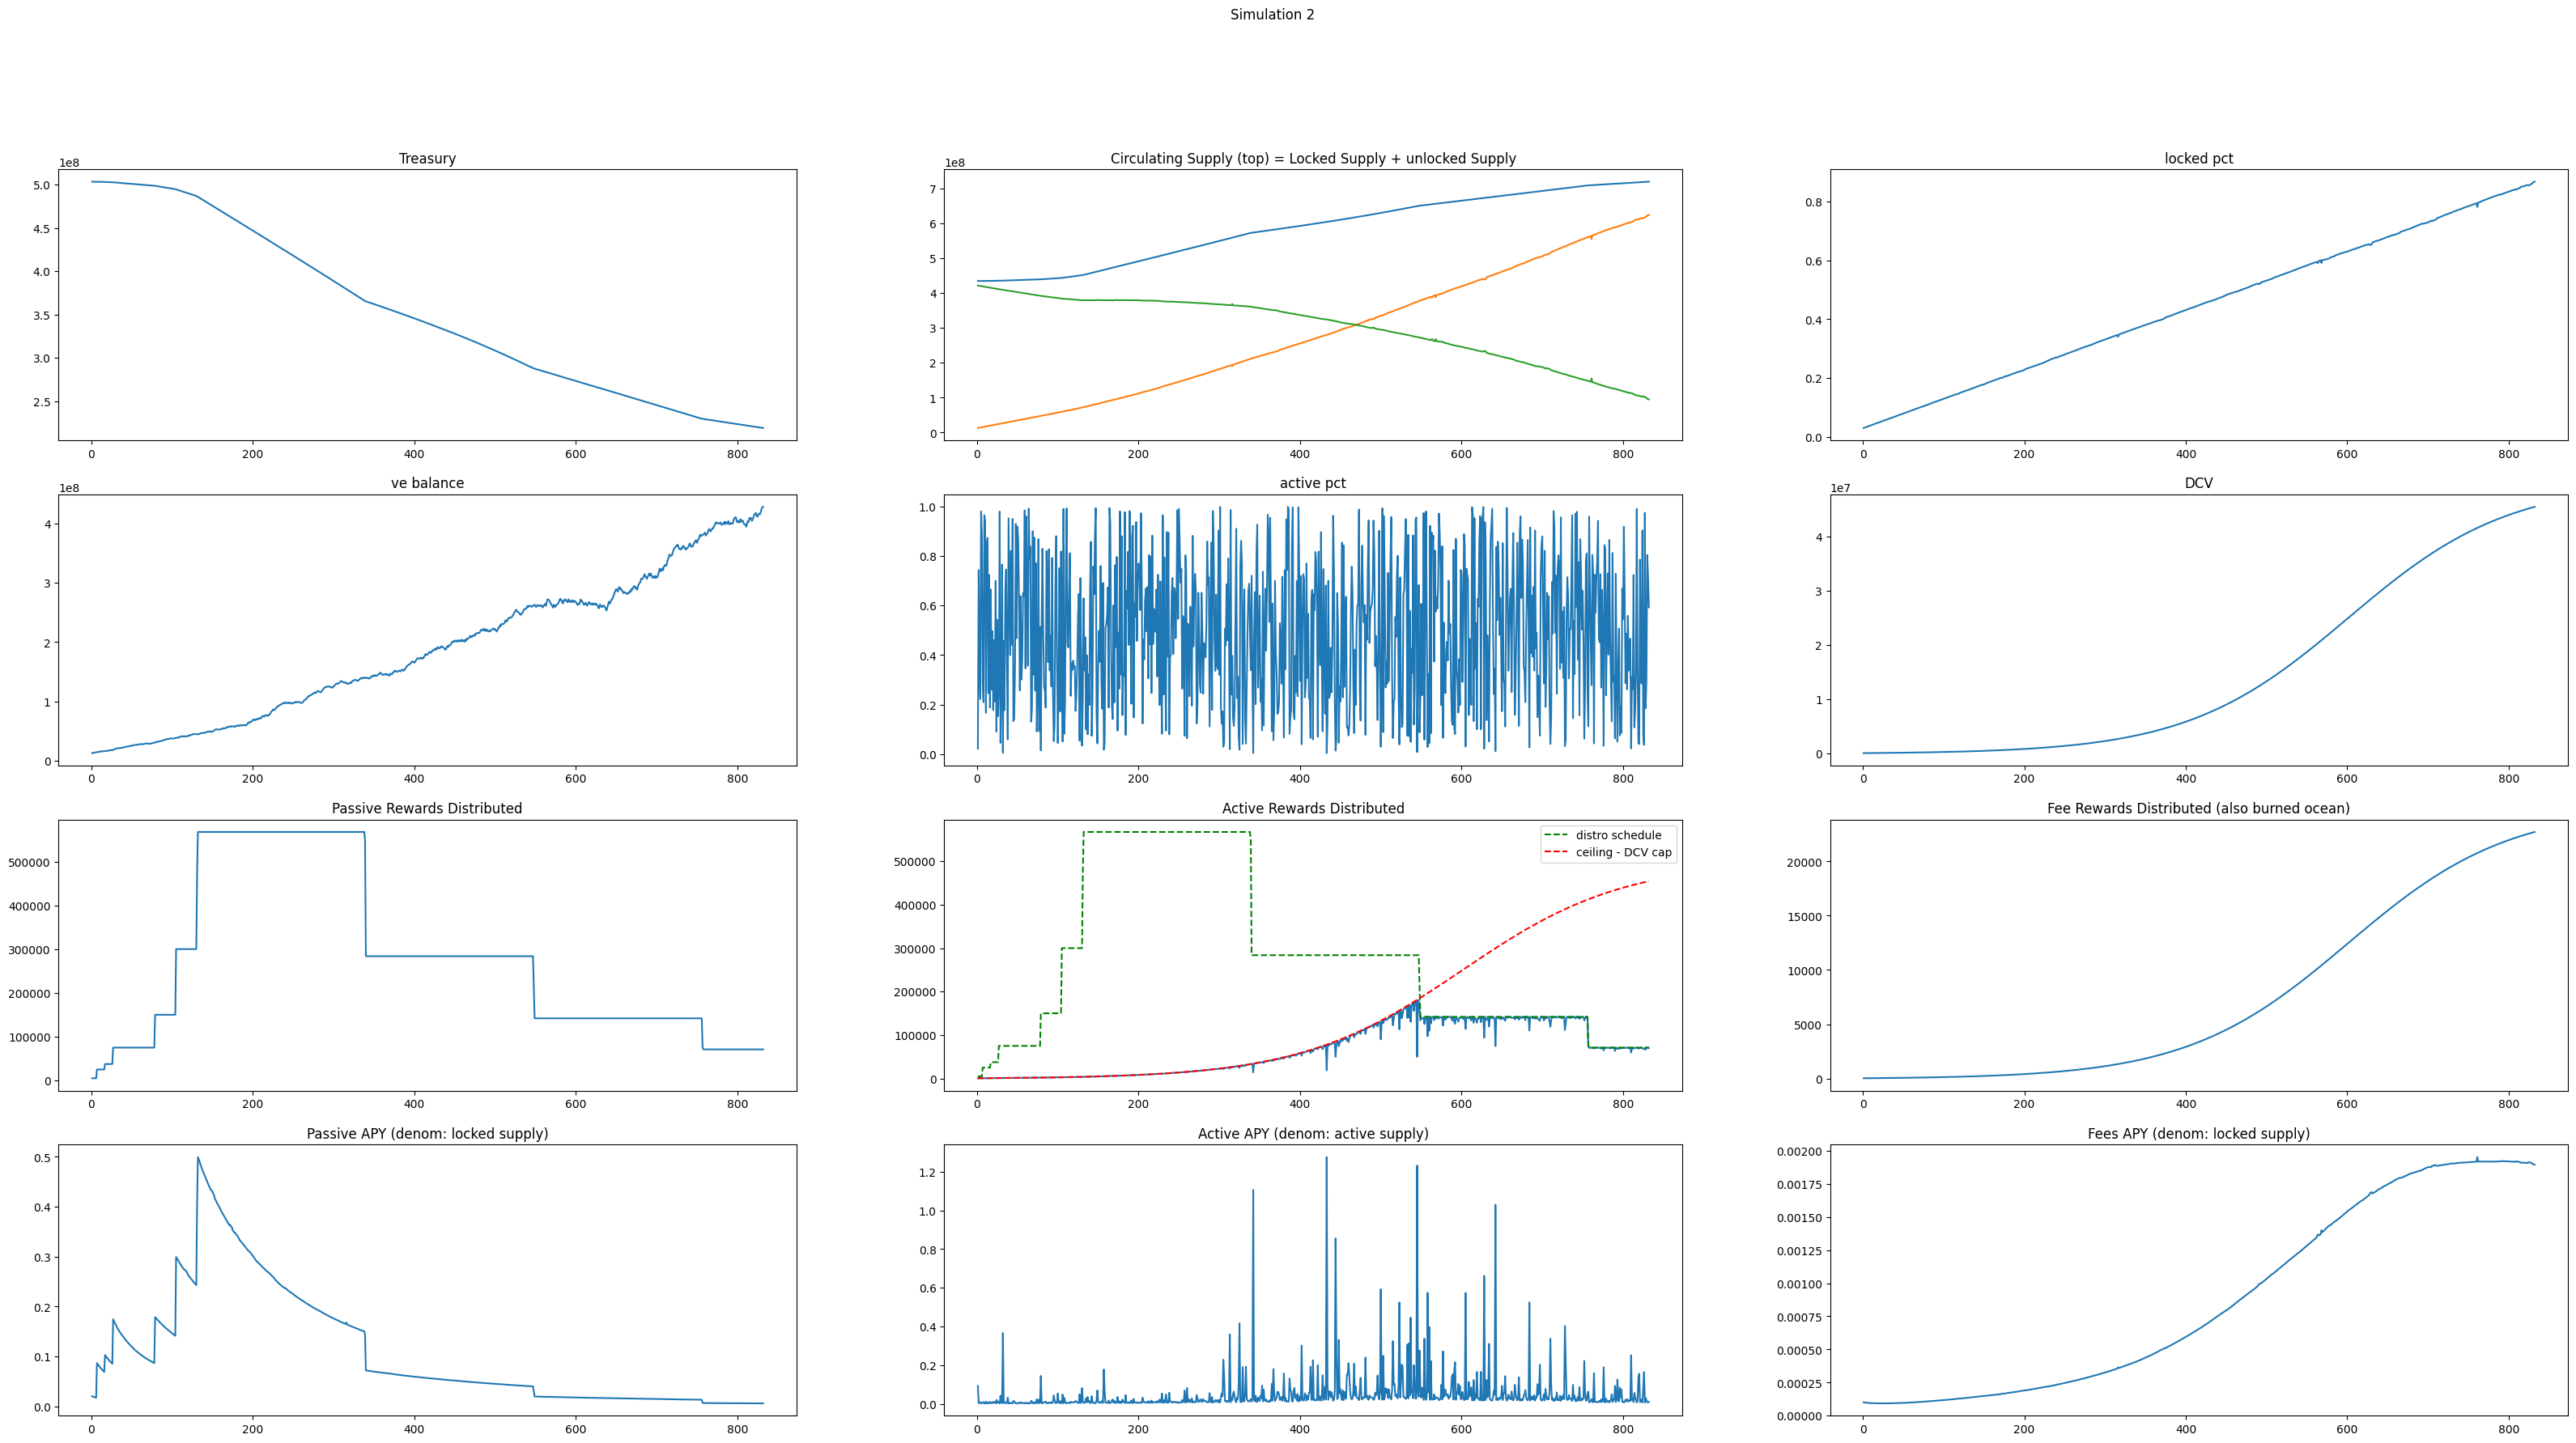

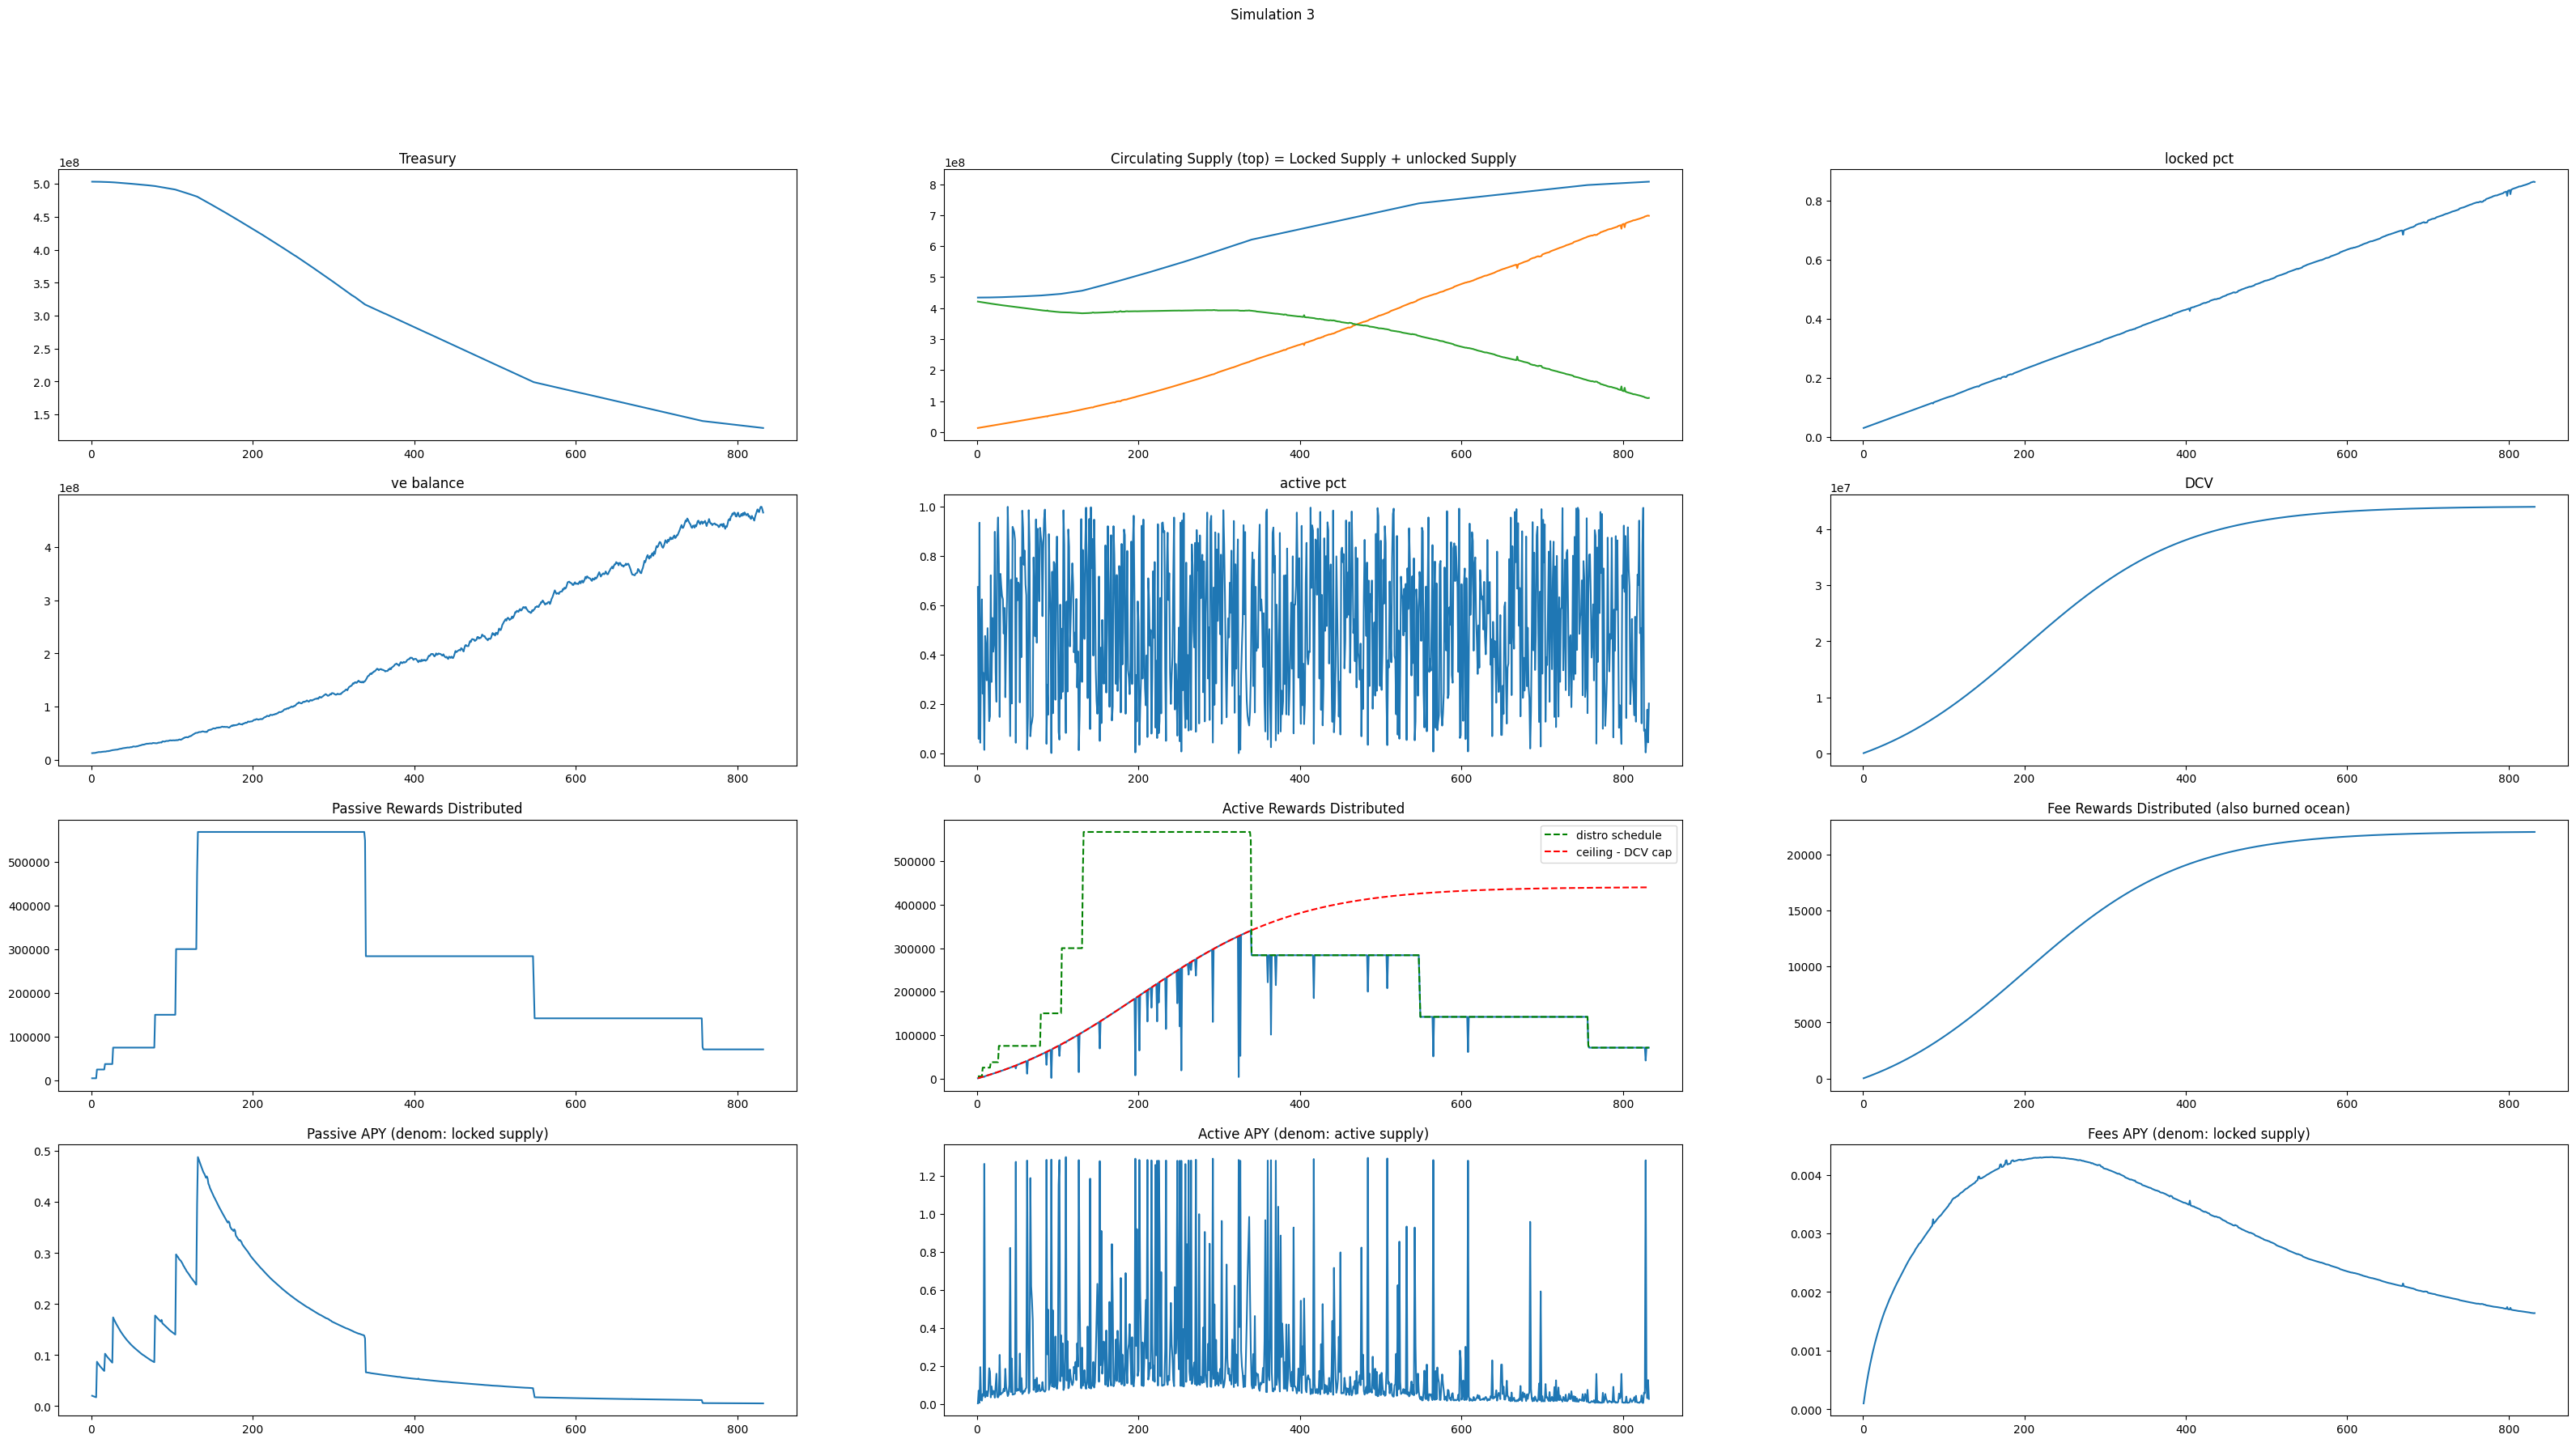

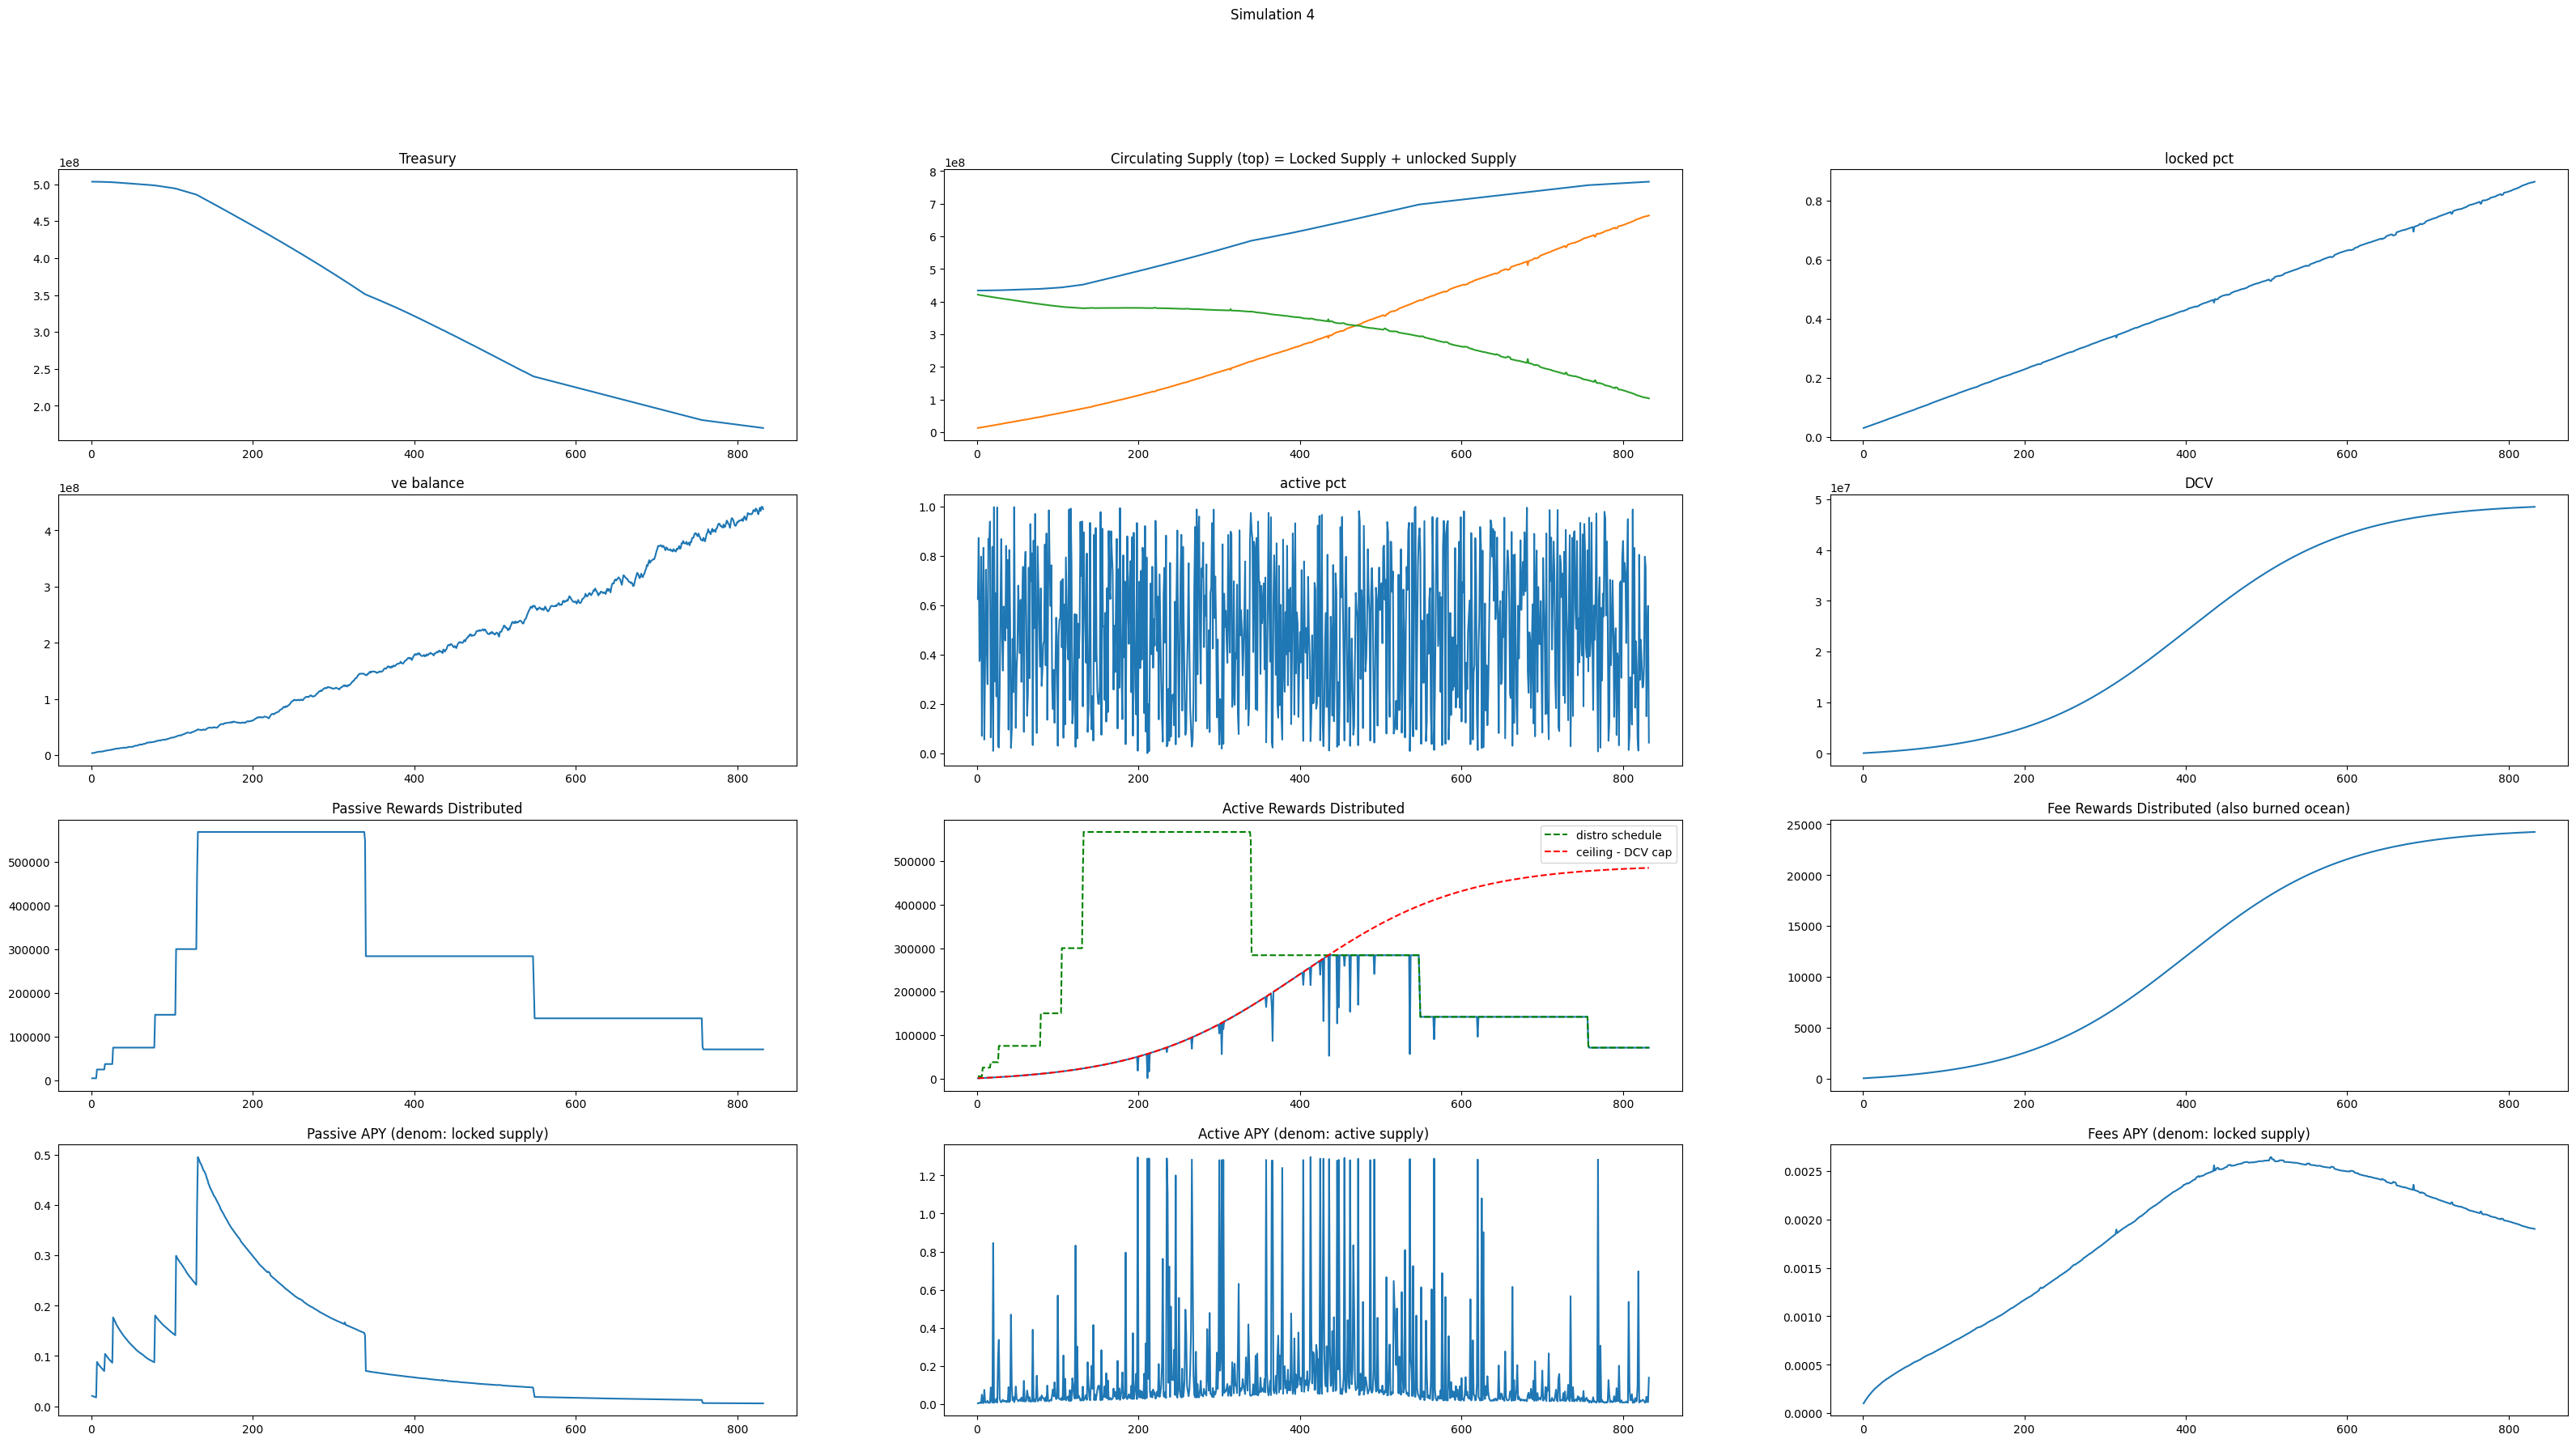

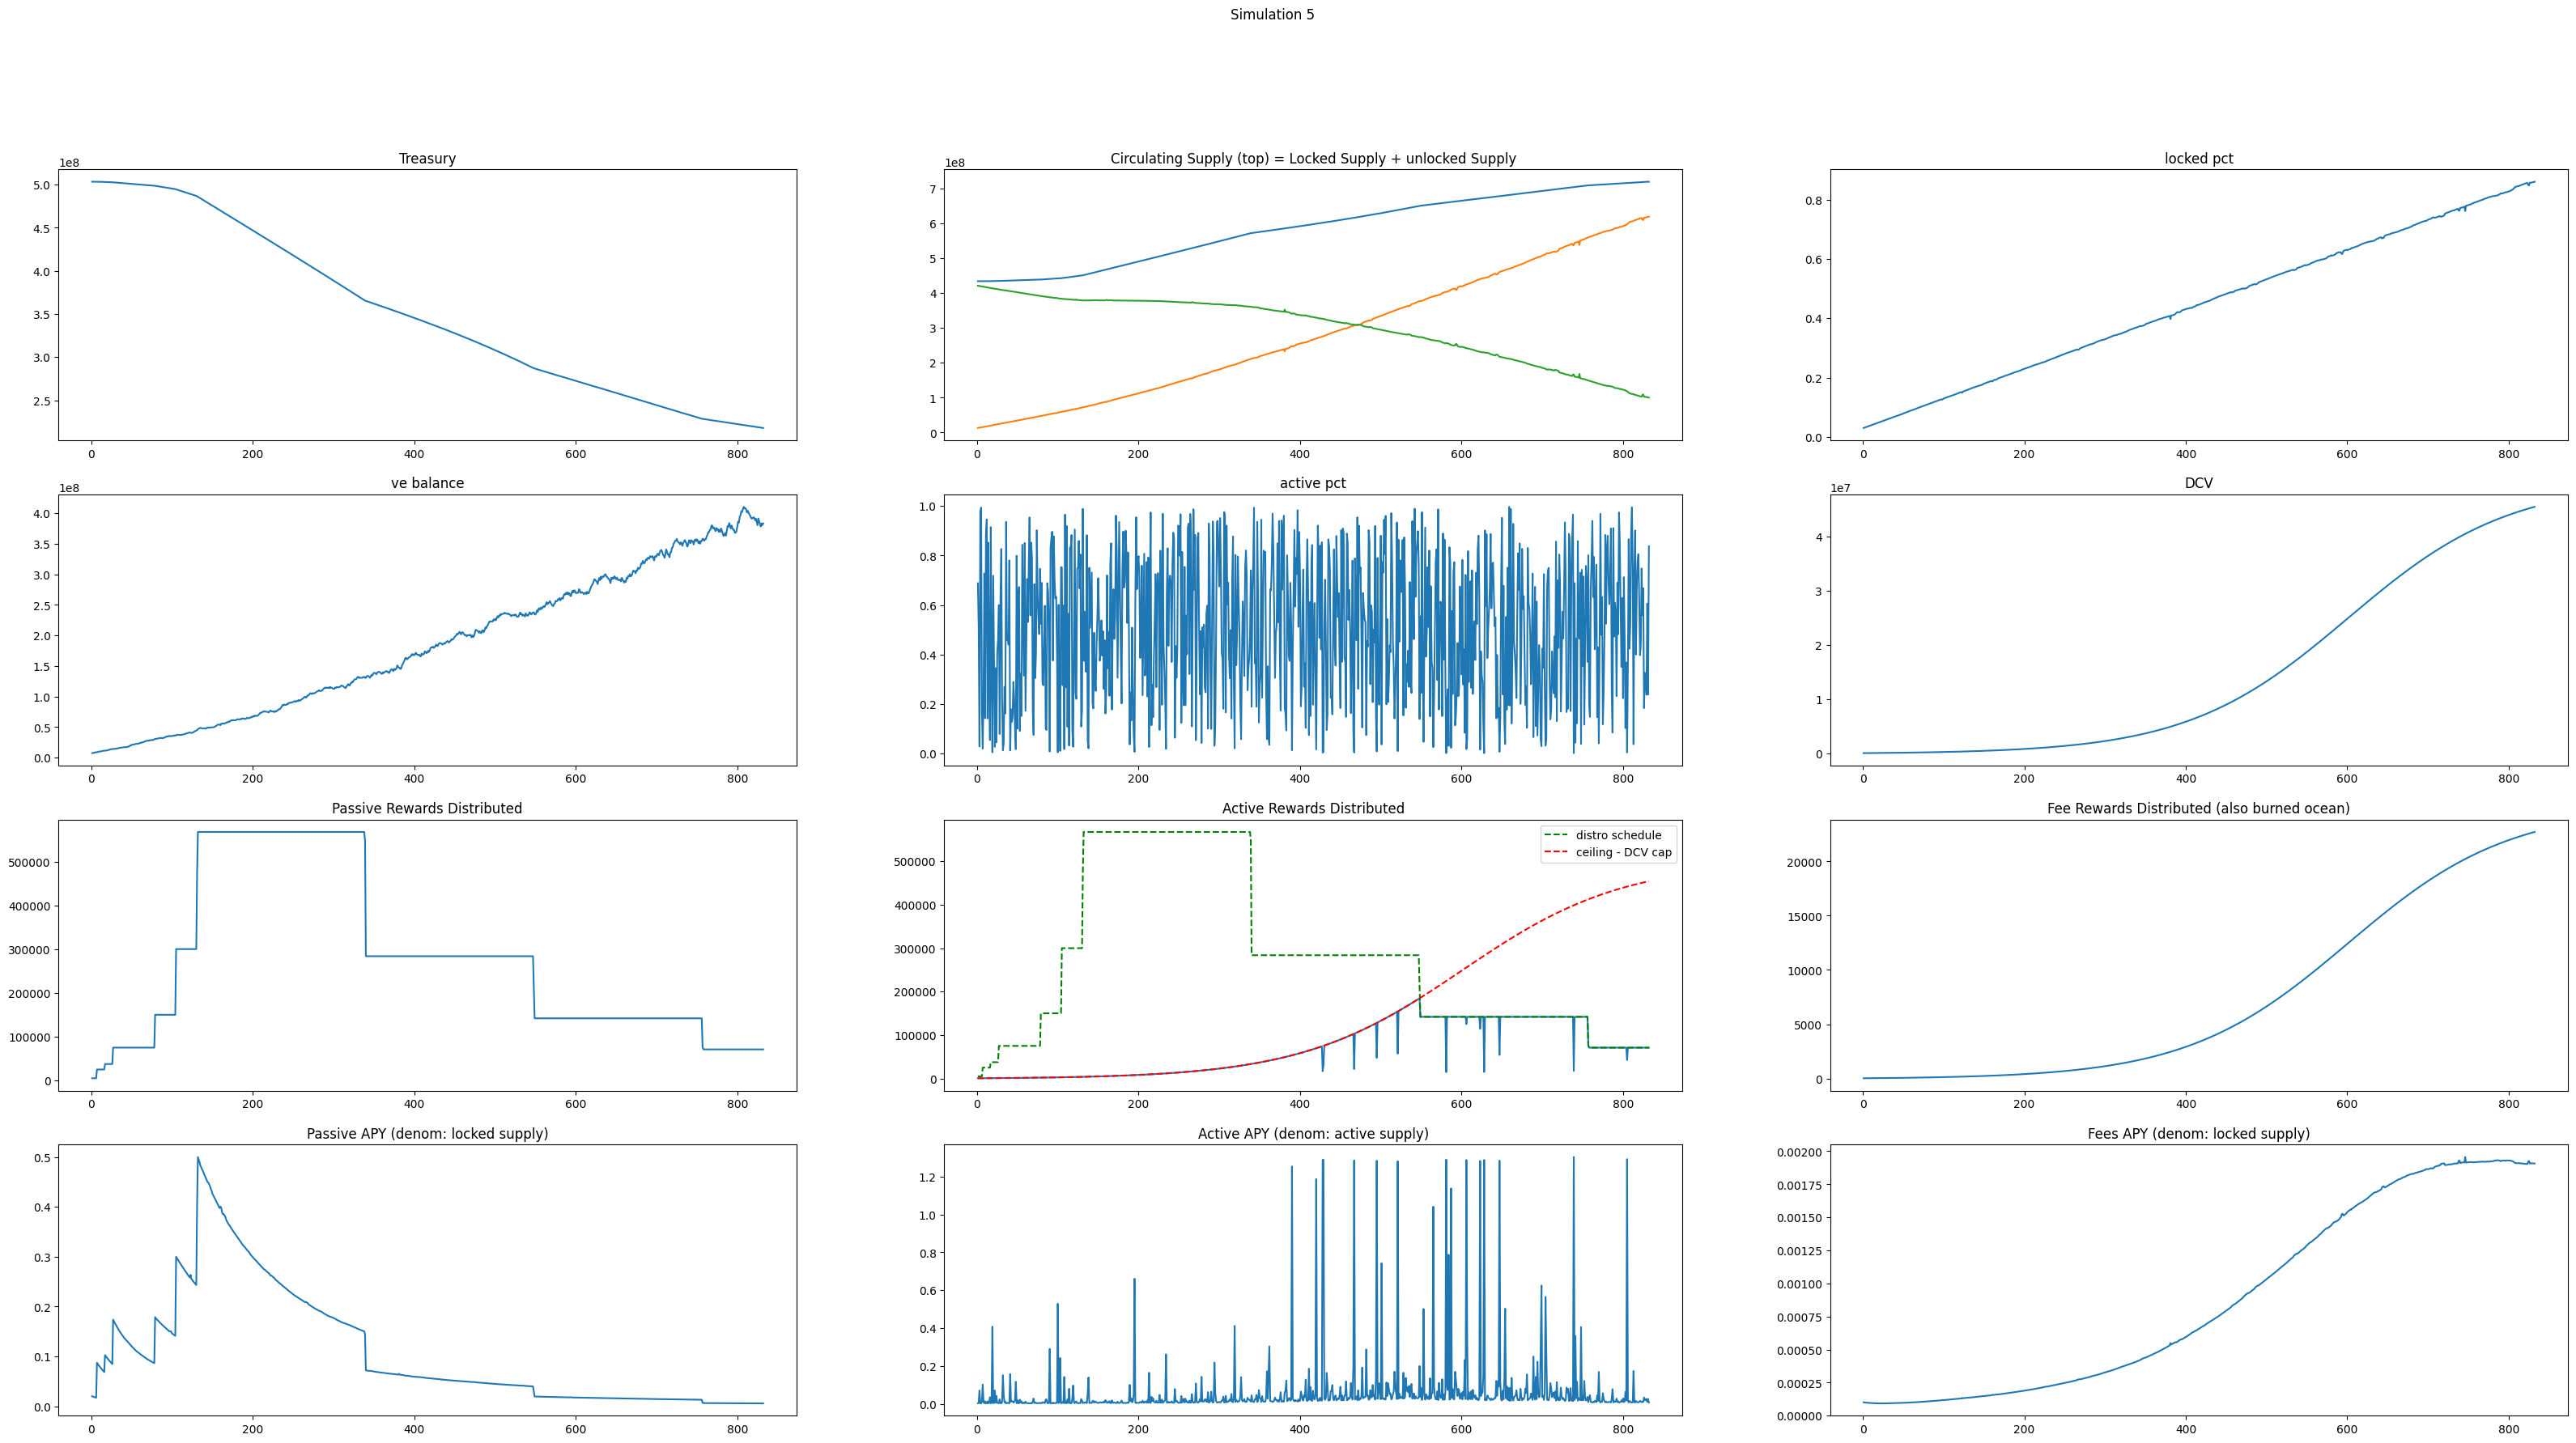

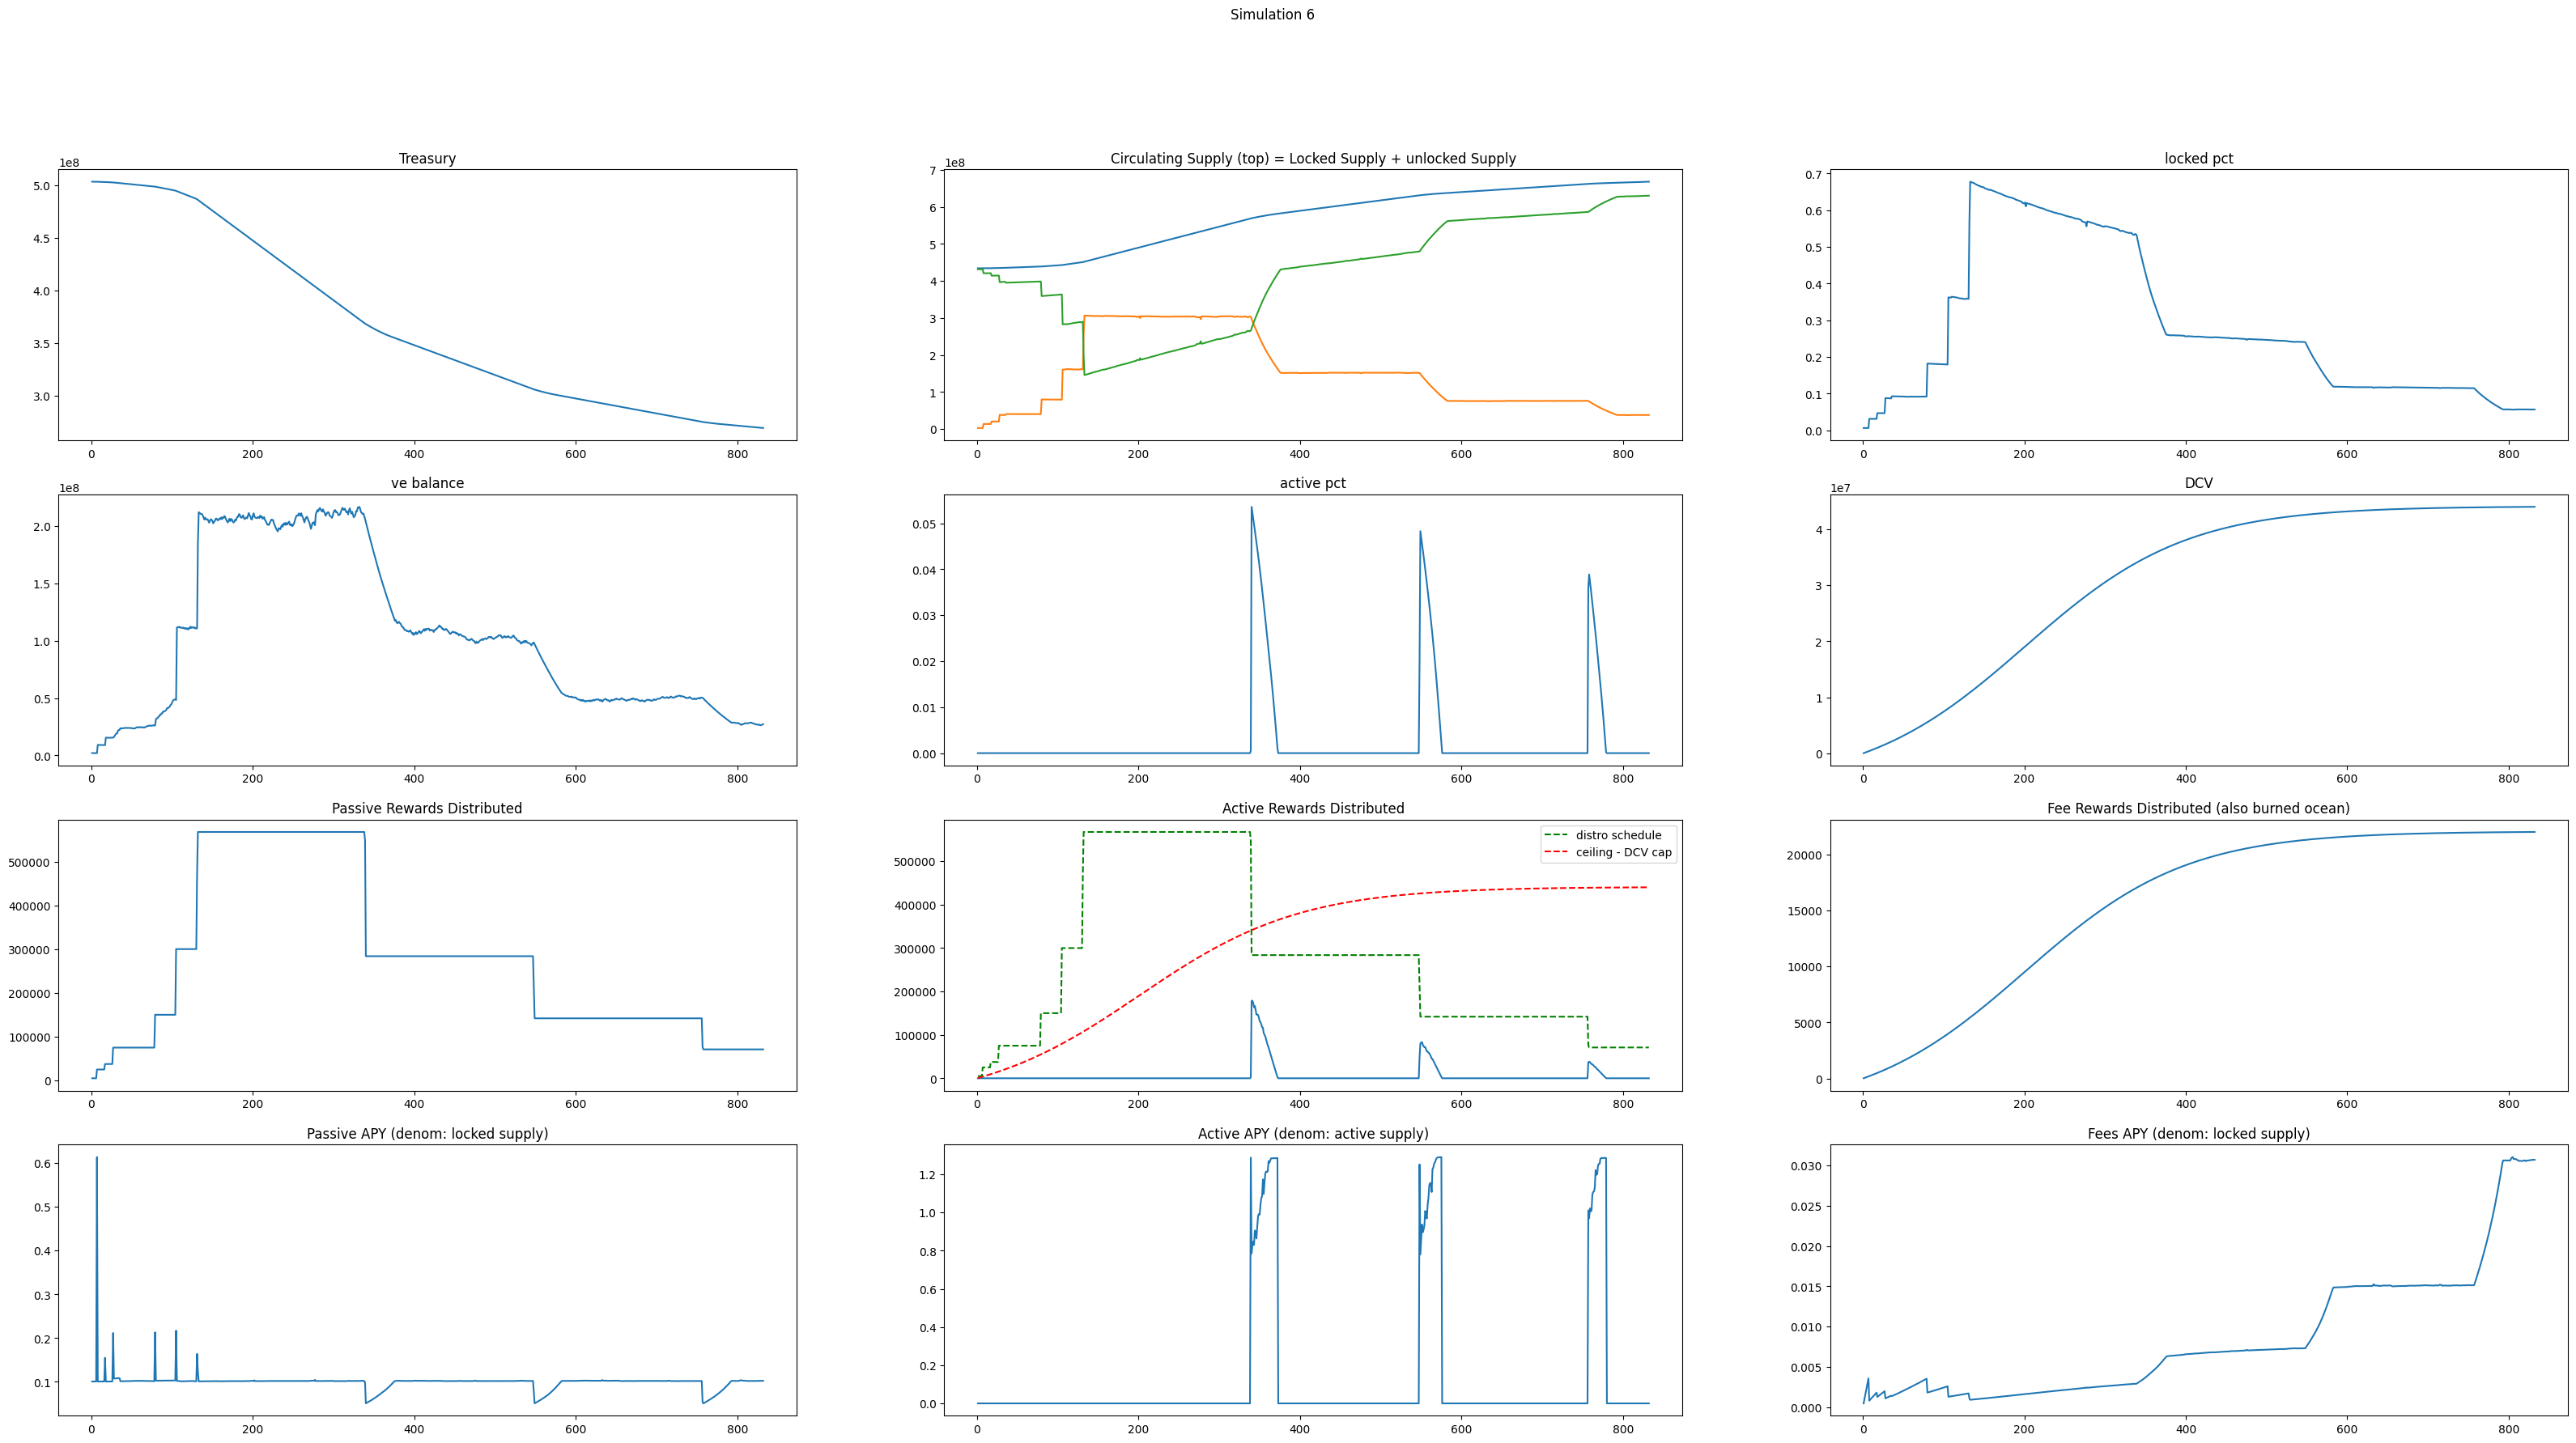

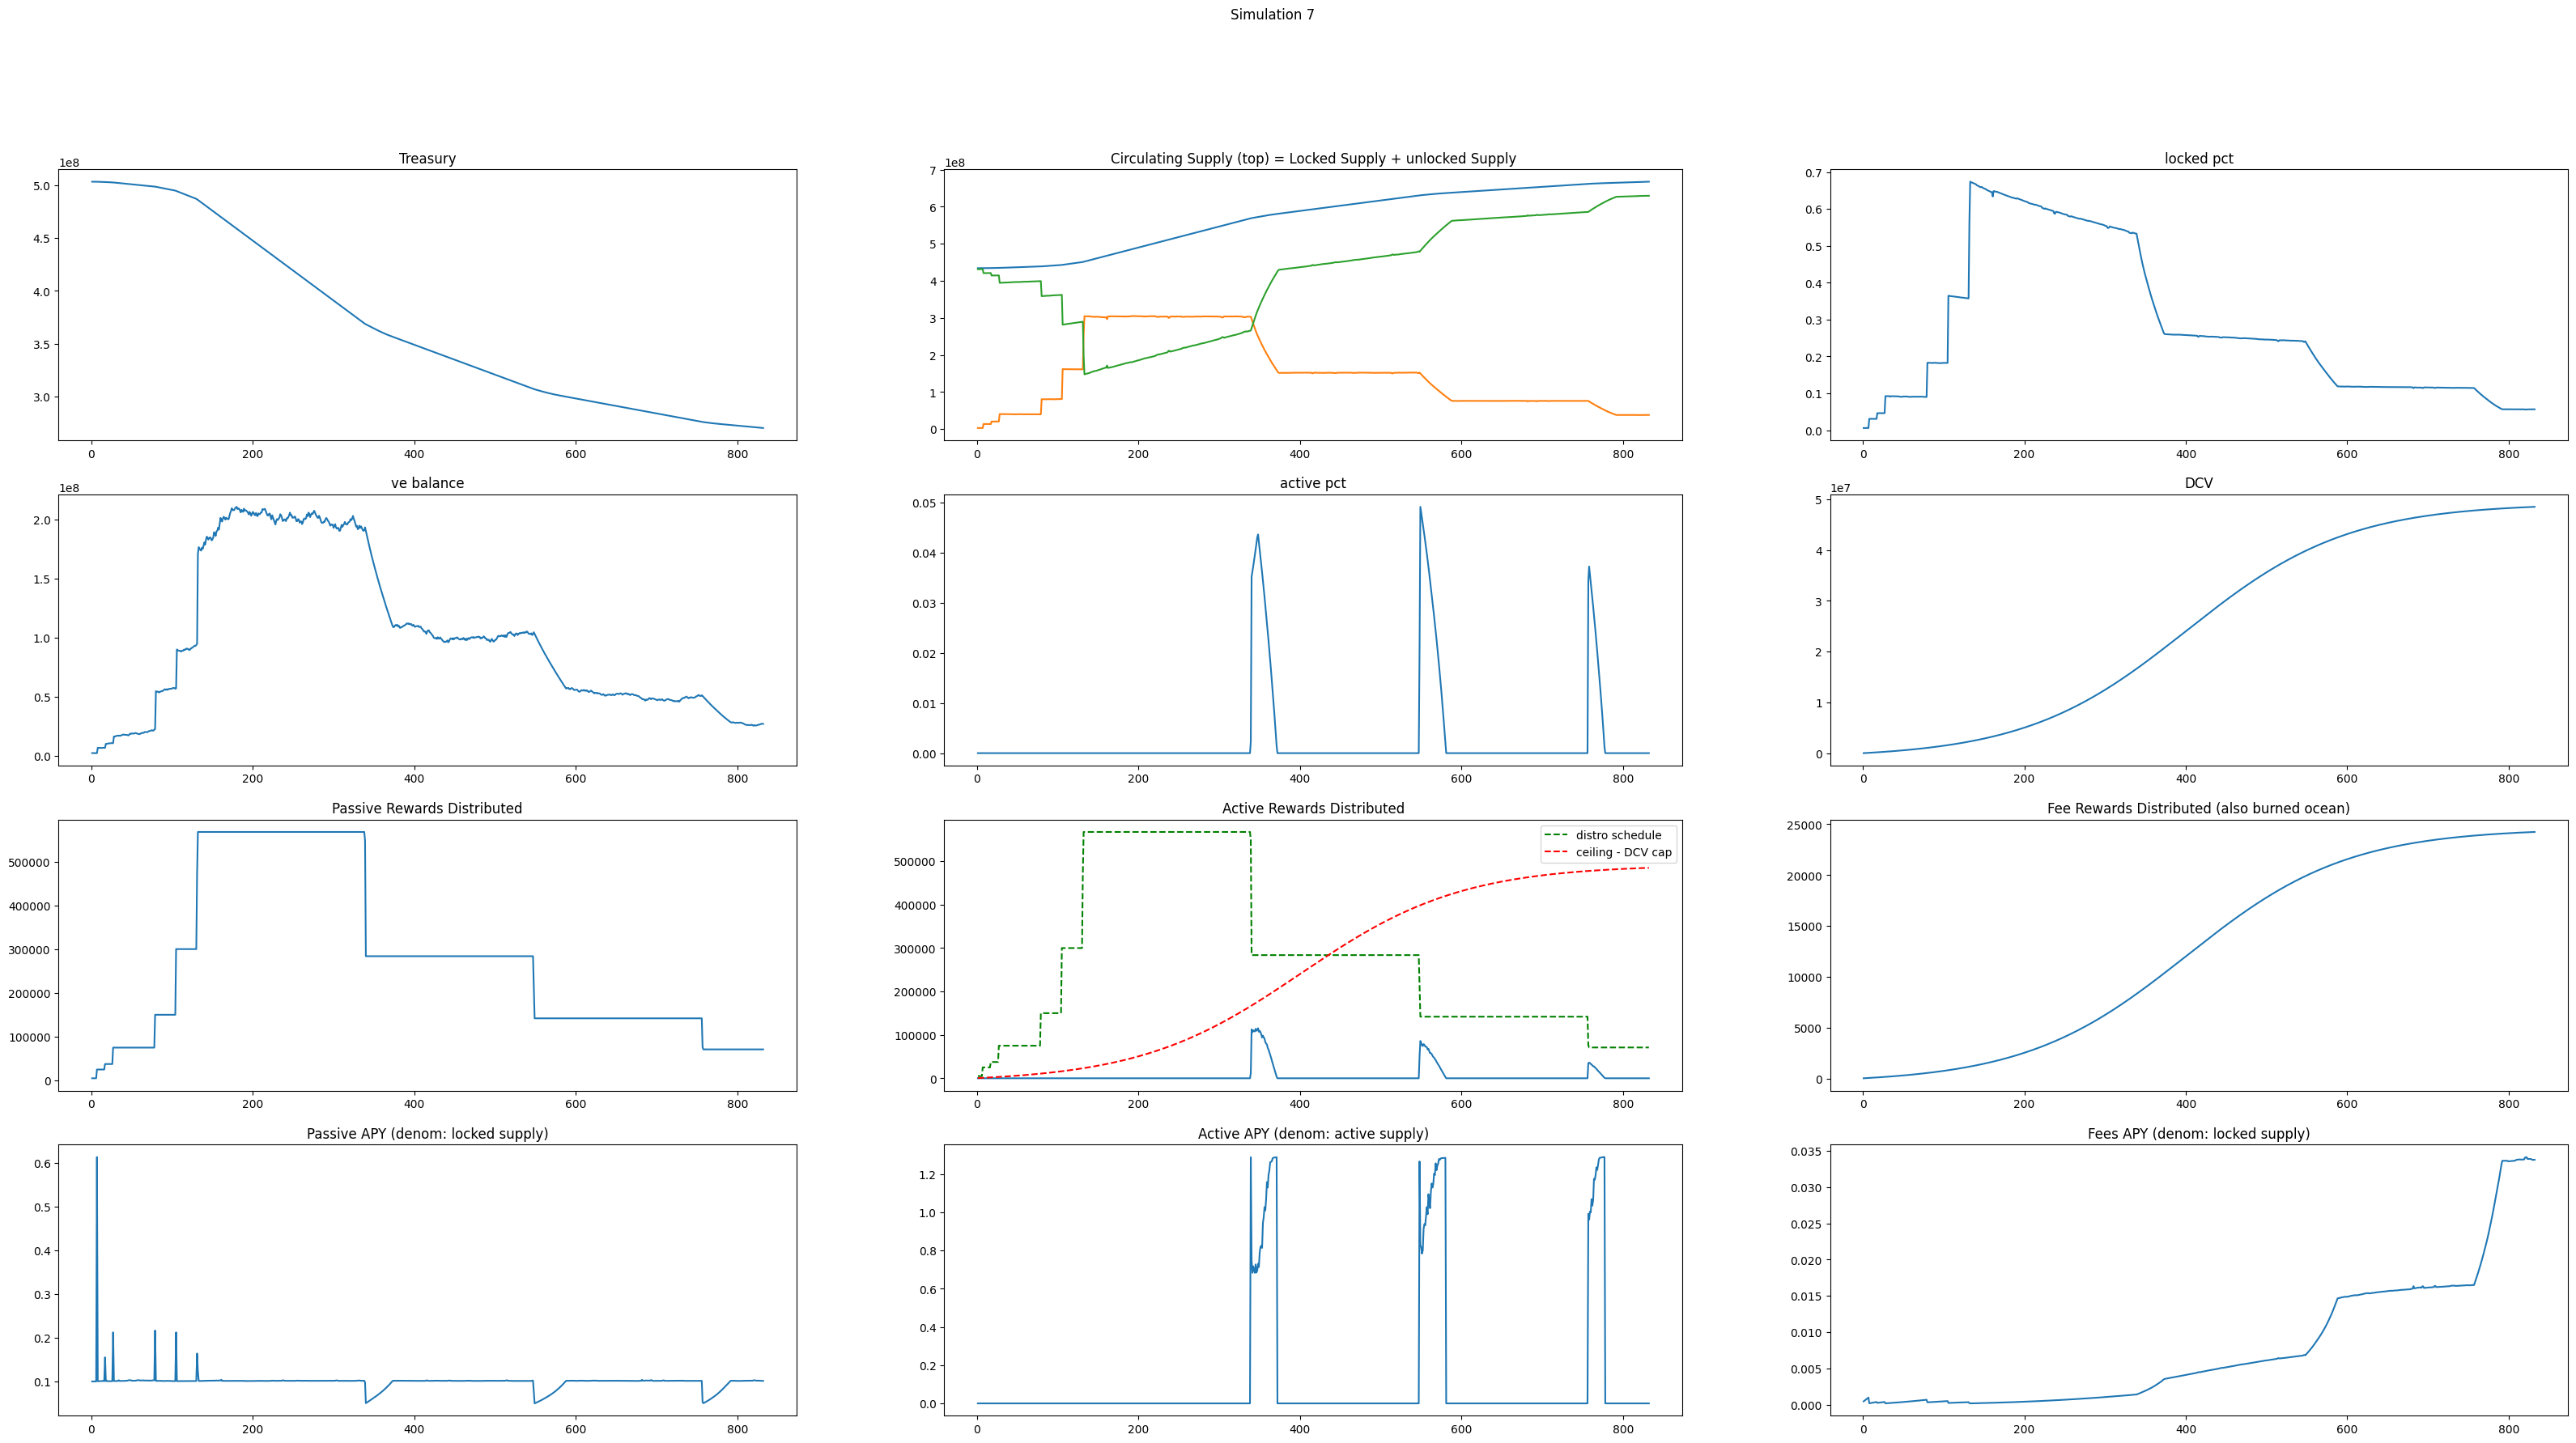

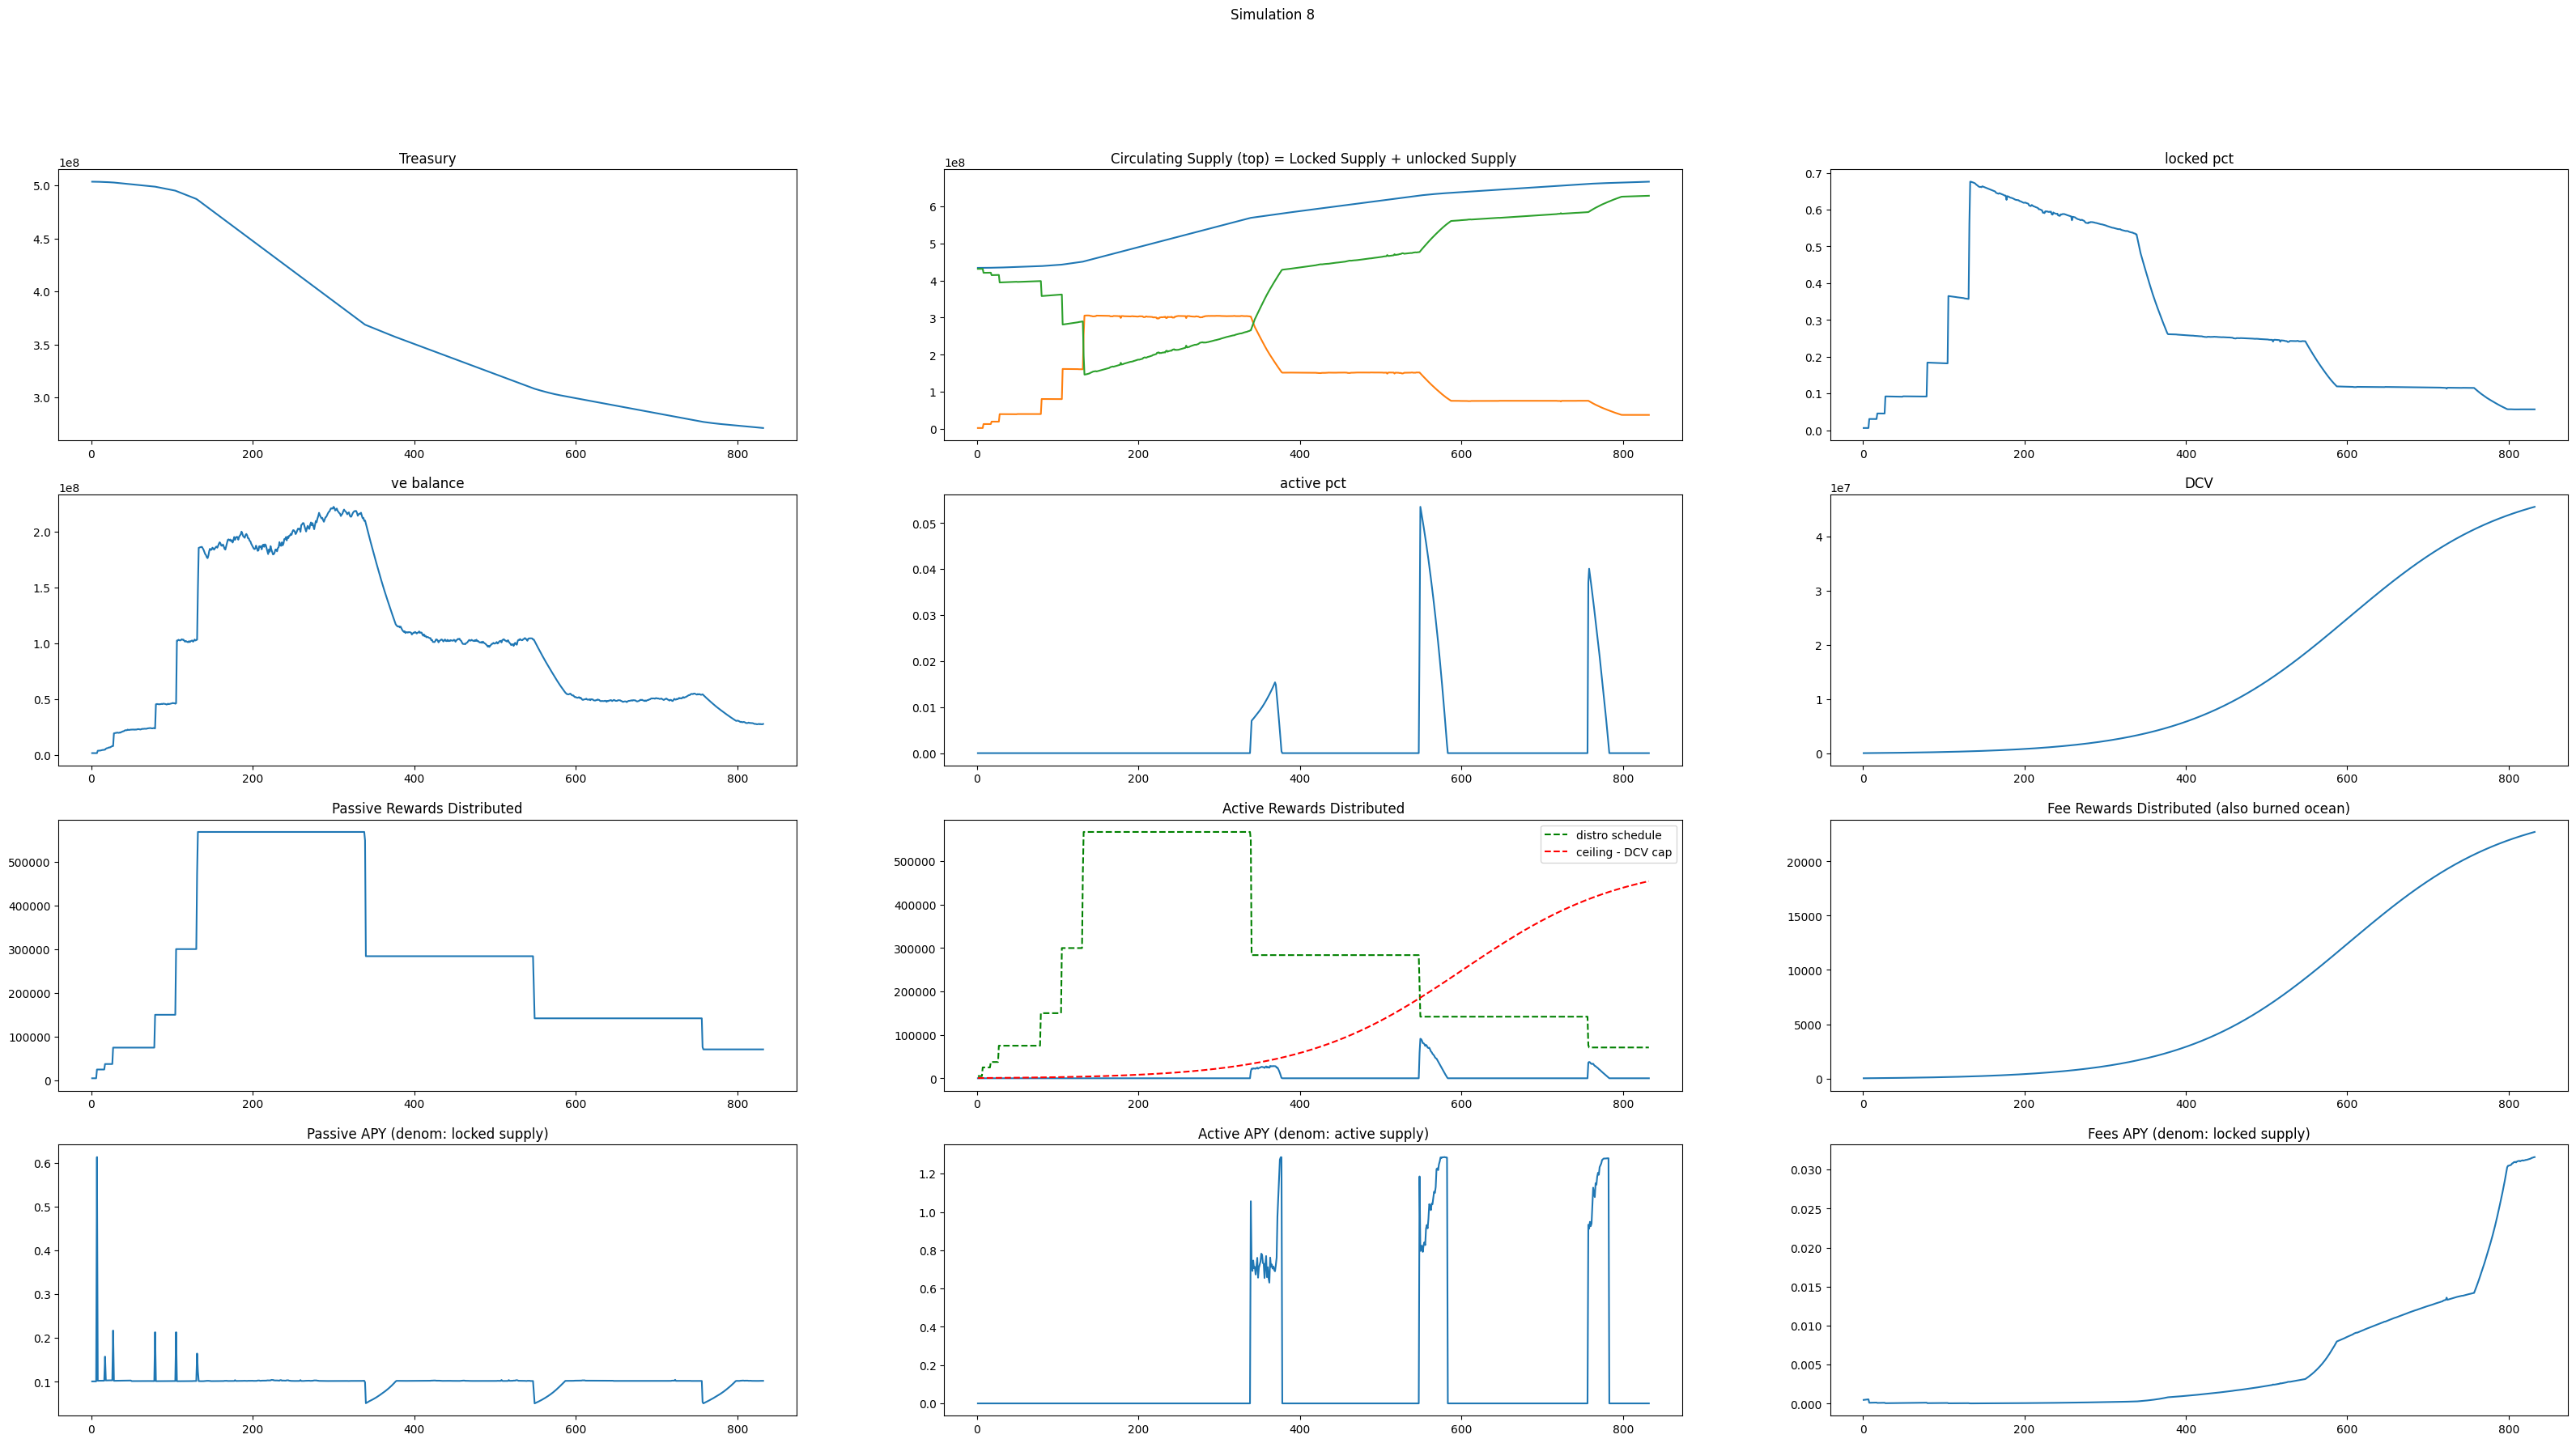

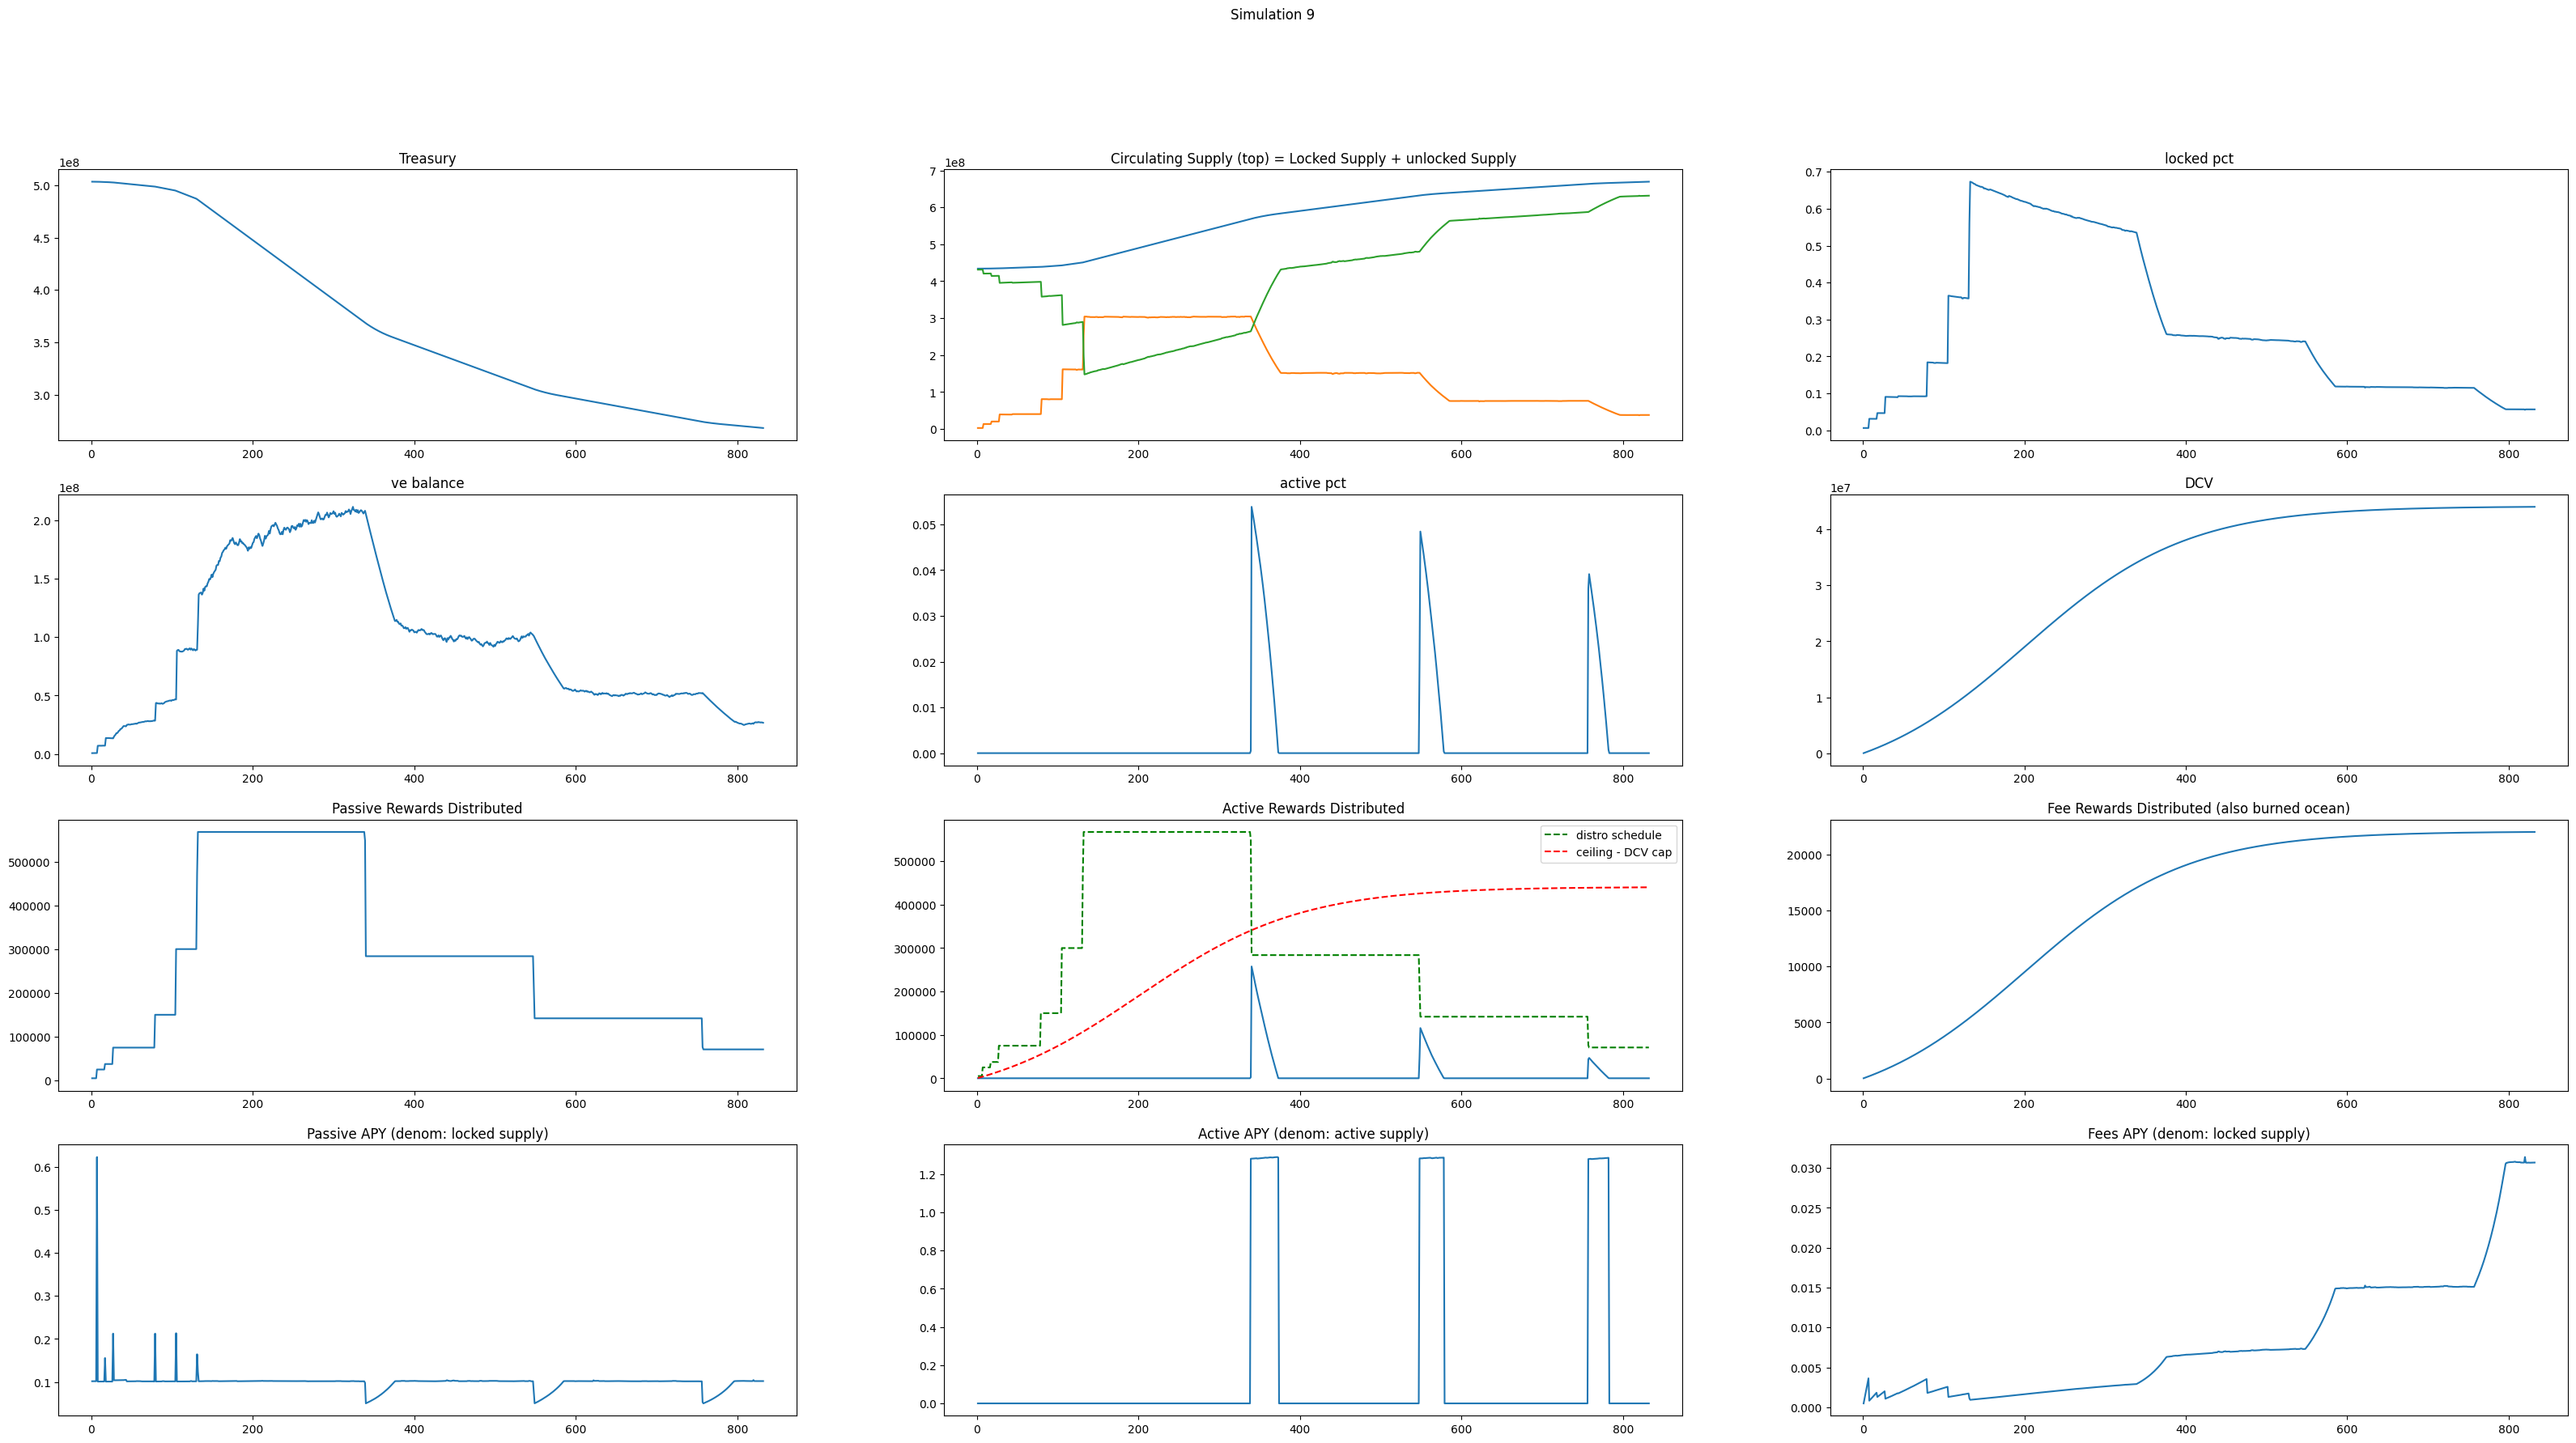

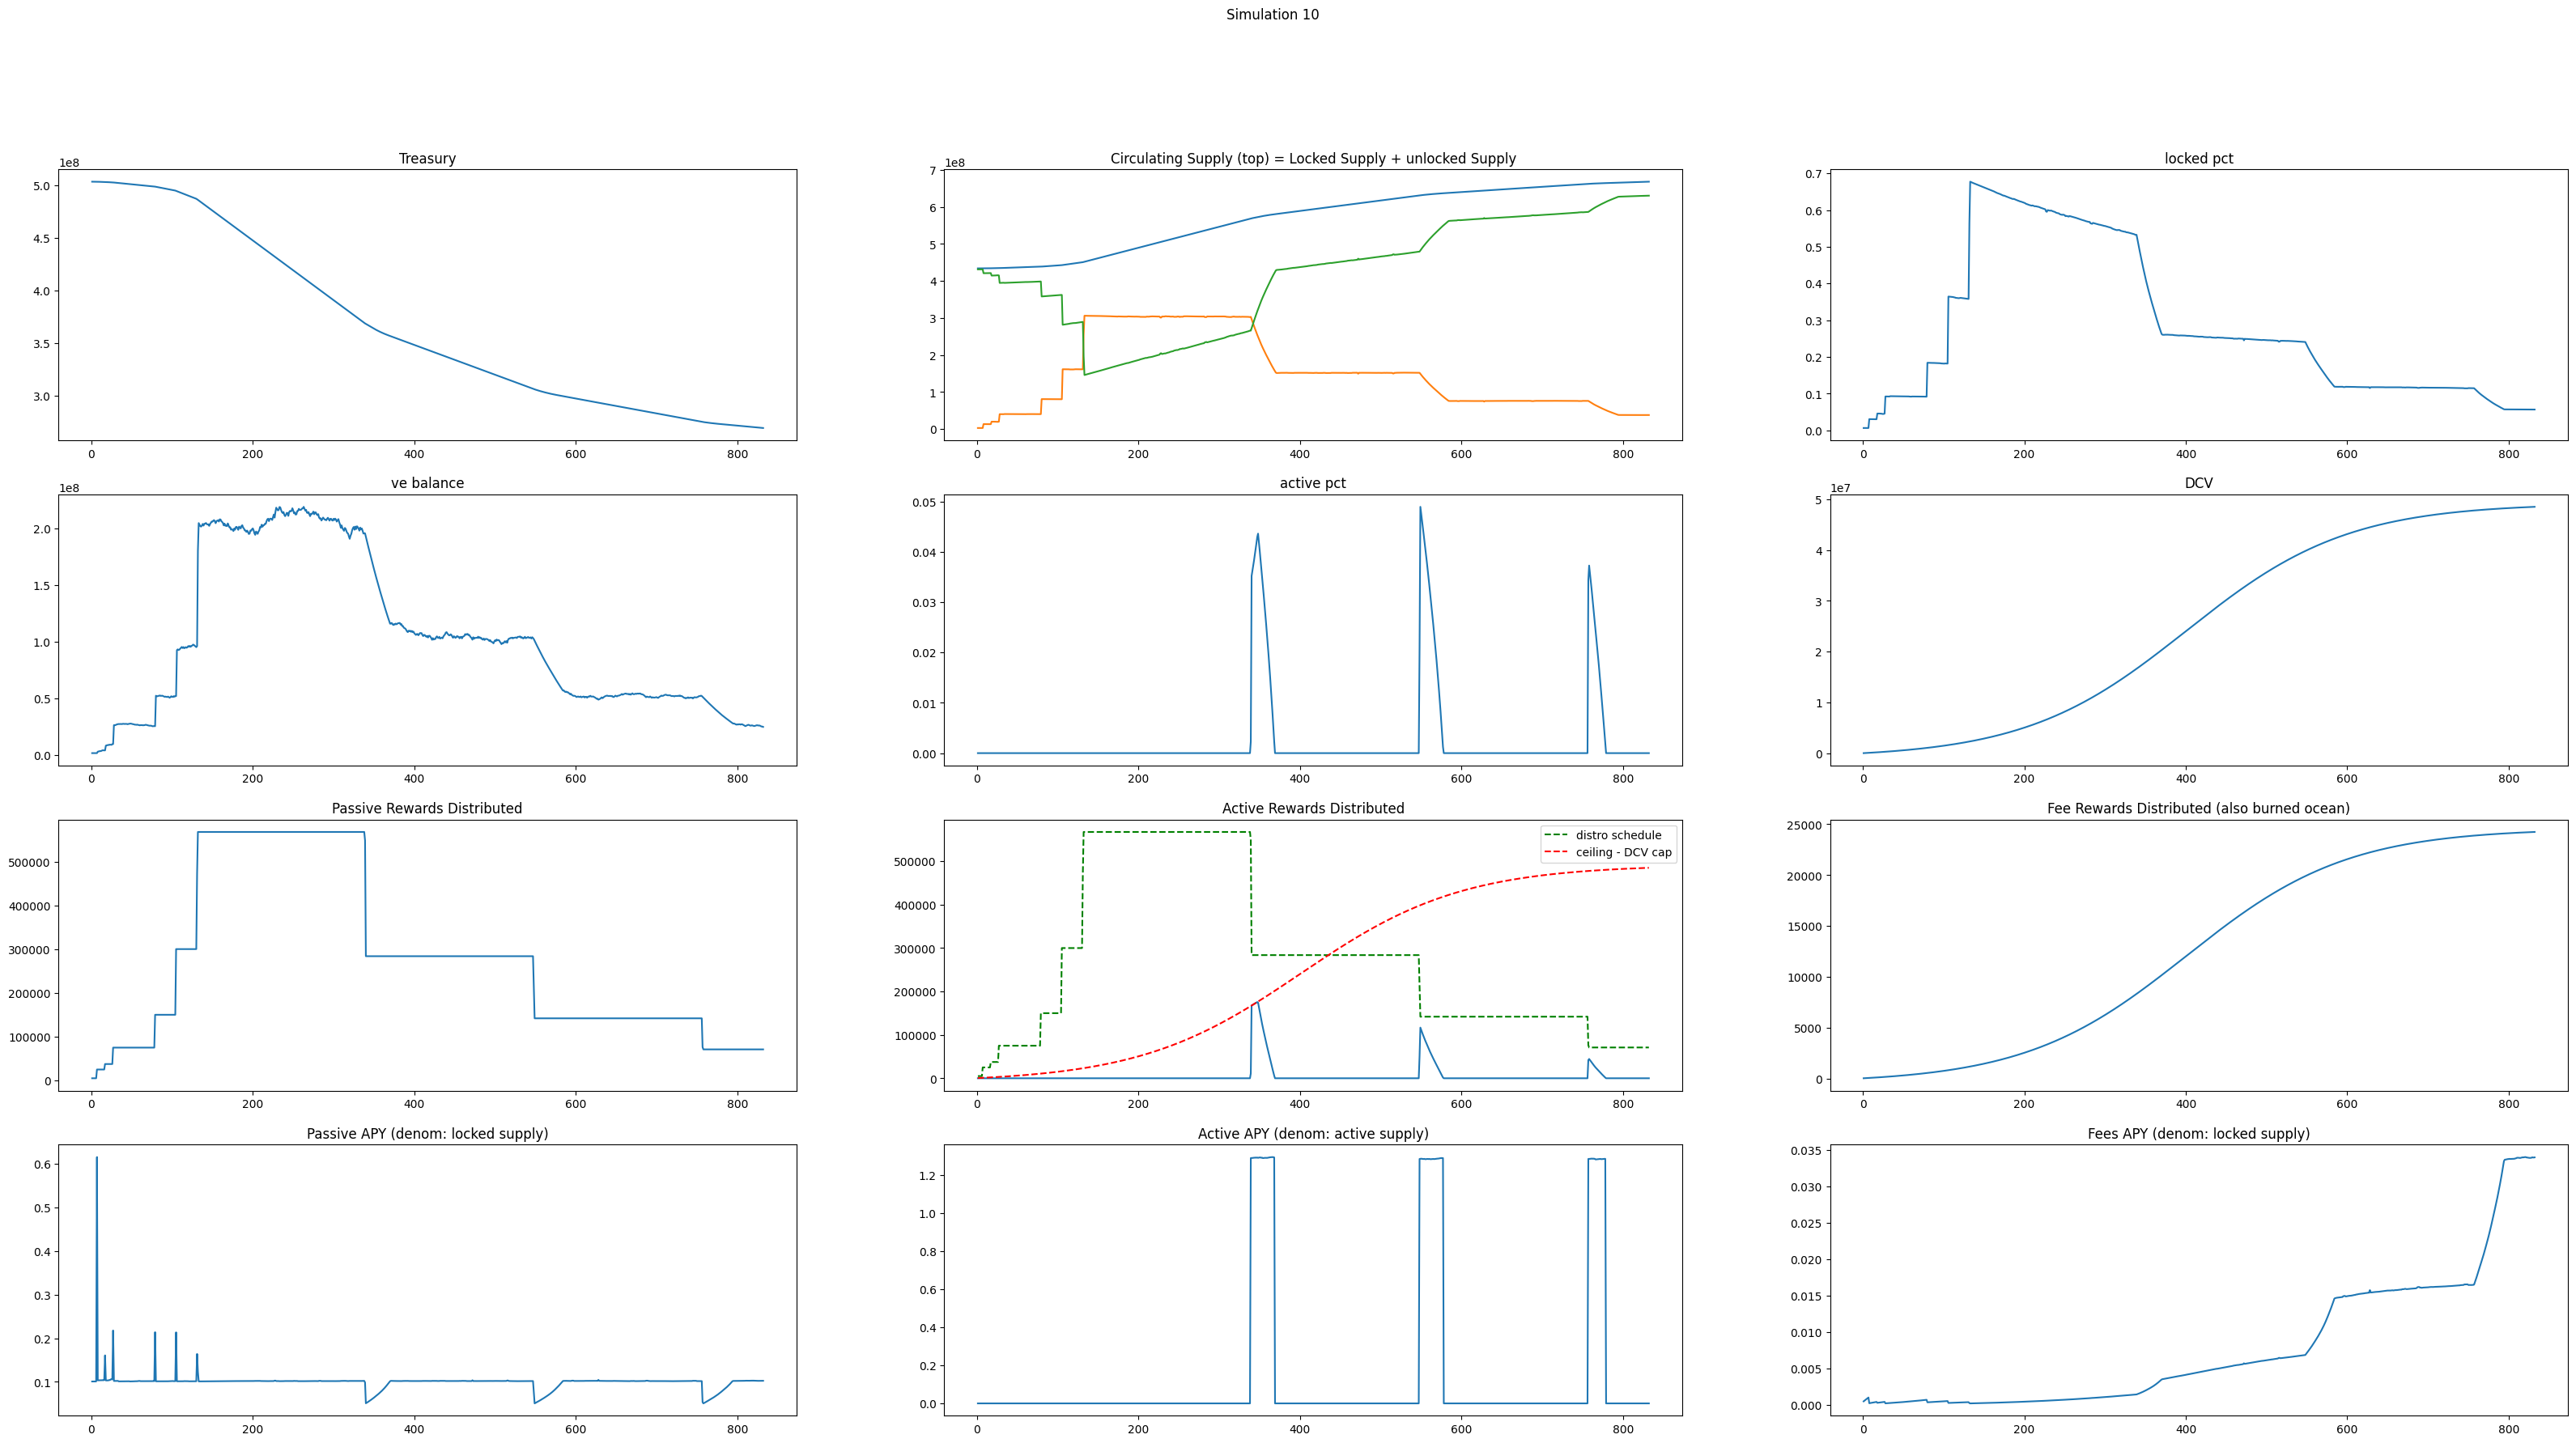

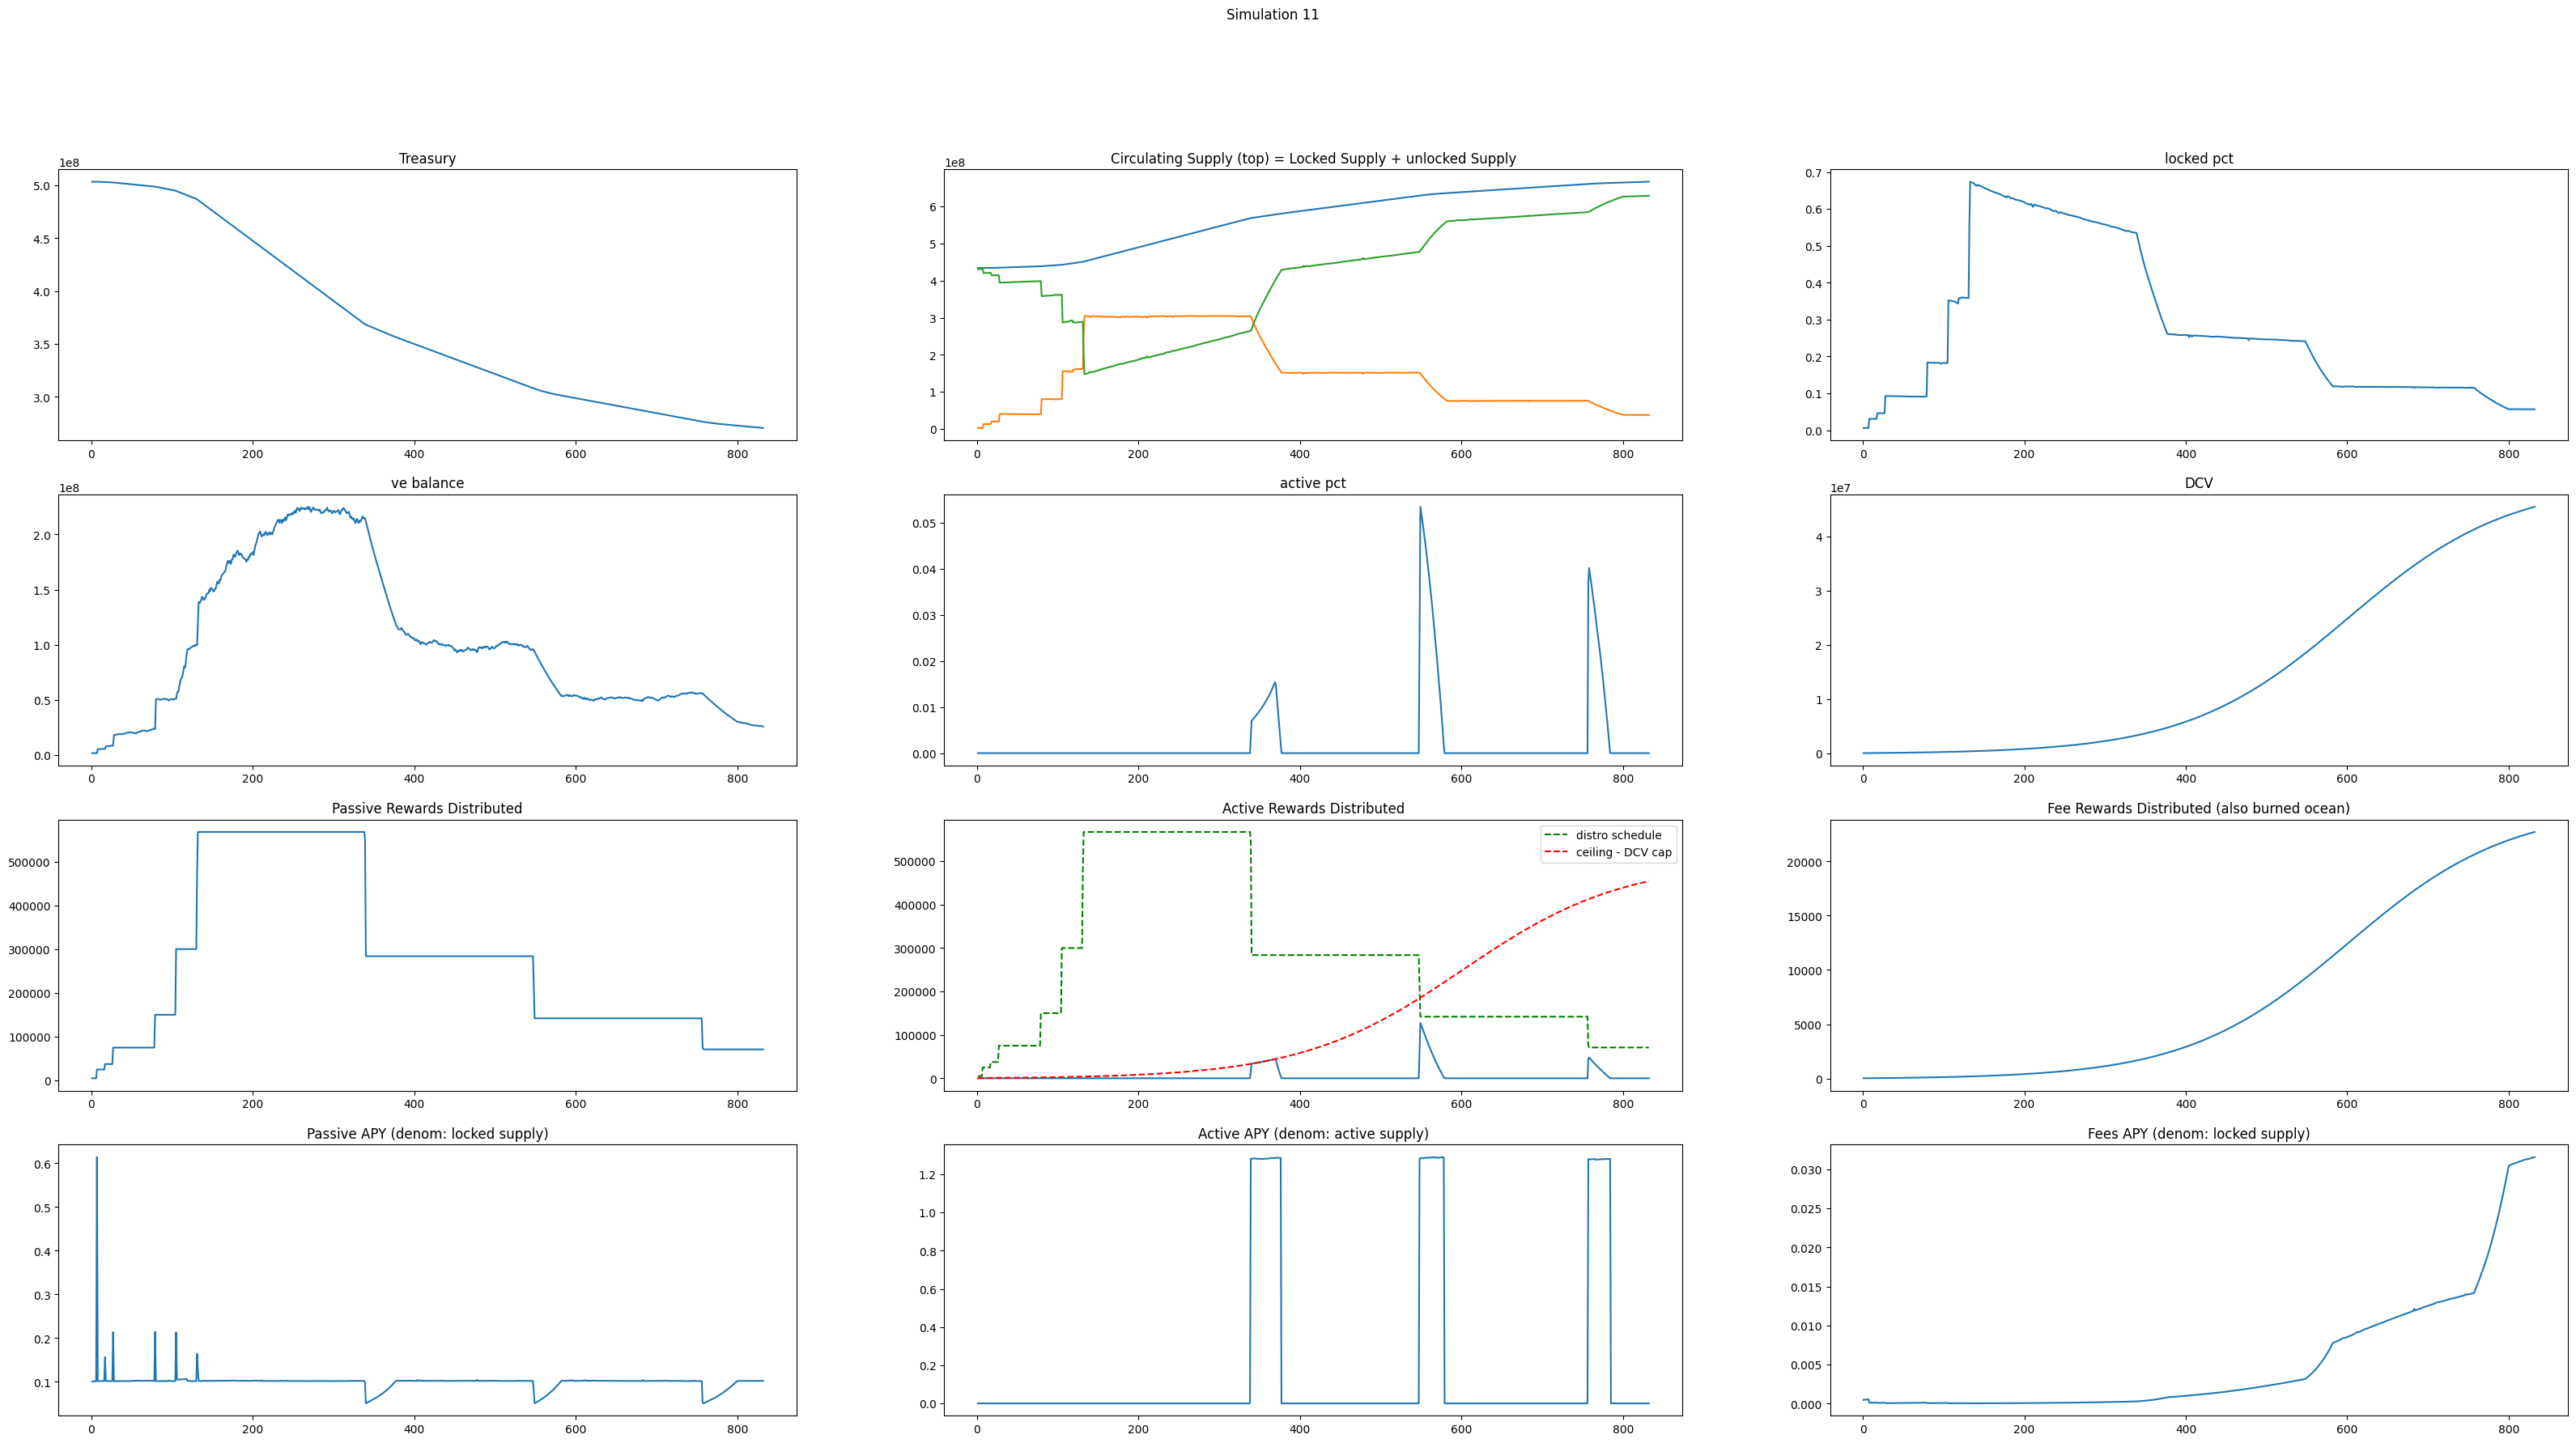

In [10]:
# plot monte carlo runs
for sim in range(0, max(df_p.simulation) + 1):
    df_tmp0 = df_p[df_p.simulation == sim]
    fig, ax = plt.subplots(4,3, figsize=(40,20))
    for run in range(1, max(df_p.run)+1):
        df_tmp = df_tmp0[df_tmp0.run == run]
        ax[0,0].plot(df_tmp.timestep, df_tmp.ocean_treasury)
        ax[0,1].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply + df_tmp.locked_supply)
        ax[0,1].plot(df_tmp.timestep, df_tmp.locked_supply)
        ax[0,1].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply)
        ax[0,2].plot(df_tmp.timestep, df_tmp.pct_locked)
        ax[1,0].plot(df_tmp.timestep, df_tmp.ve_balance)
        # could plot avg lock duration??? # driver: locking behavior
        ax[1,1].plot(df_tmp.timestep, df_tmp.active_pct) # driver: voting behavior (uniform random)
        # something for asset-level voting success / distribution # driver: voting behavior (uniform random)
        # x = sort by dataconsumevolume, y = pct of veocean allocated to asset
        ax[1,2].plot(df_tmp.timestep, df_tmp.dcv) # driver: DCV growth rate
        ax[2,0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive) # driver: distribution schedule
        ax[2,1].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active) # driver: distribution schedule & locking behavior & voting behavior (floor: 0% active or 0% voting success & middle: active_pct/voting success & asset-level success/distribution) & Rewards Function (ceiling: DCV*0.1 or 125%APY, therefore DCV growth rate)
        ax[2,2].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees) # driver: DCV growth rate
        ax[3,0].plot(df_tmp.timestep, df_tmp.Passive_APY) #driver: distro schedule & locking behavior
        ax[3,1].plot(df_tmp.timestep, df_tmp.Active_APY) #driver: distro schedule & locking behavior & voting behavior(active pct & asset-level voting success)
        ax[3,2].plot(df_tmp.timestep, df_tmp.Fees_APY) #driver: DCV growth rate & locking behavior
        #ax[3,3].plot(df_tmp.timestep, df_tmp.Agg_APY)
            
    ax[2,1].plot(df_tmp0[df_tmp0.run == 1].timestep, df_tmp0[df_tmp0.run == 1].rewards_distributed_df_passive, label='distro schedule', color='green', linestyle='--')
    ax[2,1].plot(df_tmp0[df_tmp0.run == 1].timestep, df_tmp0[df_tmp0.run == 1].dcv * 0.01, label='ceiling - DCV cap', color='red', linestyle='--')
    
    ax[0,0].set_title('Treasury')
    ax[0,1].set_title('Circulating Supply (top) = Locked Supply + unlocked Supply')
    ax[0,2].set_title('locked pct')
    ax[1,0].set_title('ve balance')
    ax[1,1].set_title('active pct')
    #ax[1,2].set_title('something to show uniform random asset-level voting success / distribution')
    ax[1,2].set_title('DCV')
    ax[2,0].set_title('Passive Rewards Distributed')
    ax[2,1].set_title('Active Rewards Distributed')
    ax[2,2].set_title('Fee Rewards Distributed (also burned ocean)')
    ax[3,0].set_title('Passive APY (denom: locked supply)')
    ax[3,1].set_title('Active APY (denom: active supply)')
    ax[3,2].set_title('Fees APY (denom: locked supply)')
    #ax[3,3].set_title('Agg APY (denom: locked supply)')
    ax[2,1].legend()
    fig.suptitle(f"Simulation {sim}")
    plt.show()

In [16]:
def get_rolling_avg(series,window):
    out=[]
    for i in range(0,len(series)):
        if i<window:
            if i==0:
                out.append(series[i])
            else:
                out.append(np.mean(series[:i]))
        else:
            out.append(np.mean(series[i-window:i]))
    return out

#def get_rolling_avg(series_num, series_denom1, series_denom2,window):
#    out=[]
#    for i in range(0,len(series)):
#        if i<window:
#            if i==0:
#                out.append(series[i])
#            else:
#                out.append(np.mean(series[:i]))
#        else:
#            out.append(np.mean(series[i-window:i]))
#    return out

In [17]:
# df for avg monte carlo plots (avg APYs across all runs)
df_avg_apy = df_p[['simulation', 'timestep', 'rewards_distributed_df_passive', 'rewards_distributed_df_active', 'rewards_distributed_fees', 'locked_supply', 'active_pct']].reset_index(drop=True)
df_avg_apy = df_avg_apy.groupby(['simulation', 'timestep']).mean().reset_index()
df_avg_apy['avg_Agg_rewards_distributed'] = df_avg_apy['rewards_distributed_df_passive'] + df_avg_apy['rewards_distributed_df_active'] + df_avg_apy['rewards_distributed_fees']
df_avg_apy['avg_Passive_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_avg_apy['avg_Active_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['locked_supply'])) ** 52 - 1 if x['locked_supply'] != 0 and x['active_pct'] != 0 else 0, axis=1)
df_avg_apy['avg_Fees_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_fees']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
#df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
#df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: ((1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1) + x['avg_Active_APY']*x['active_pct'] if x['locked_supply'] != 0 else 0, axis=1)
df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (x['avg_Passive_APY'] + x['avg_Fees_APY'] + x['avg_Active_APY']*x['active_pct']), axis=1)


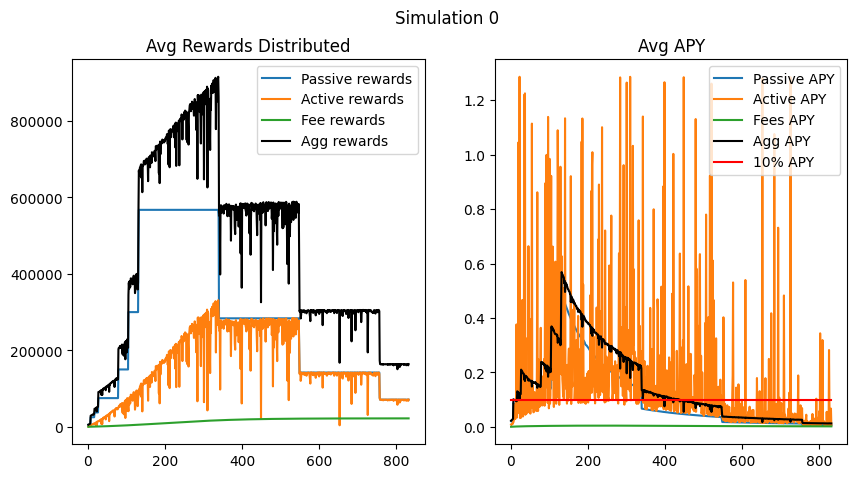

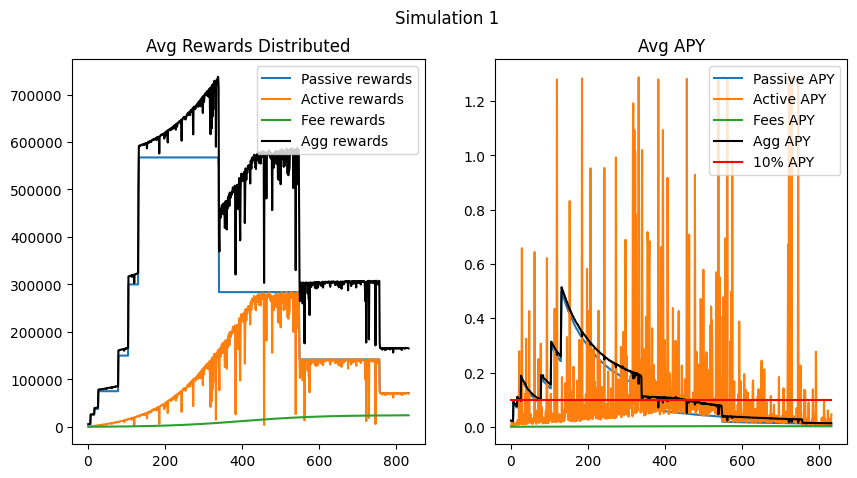

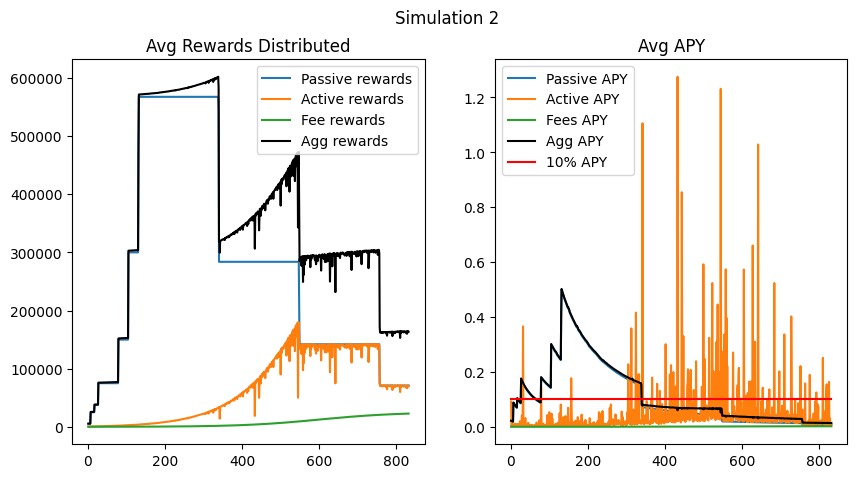

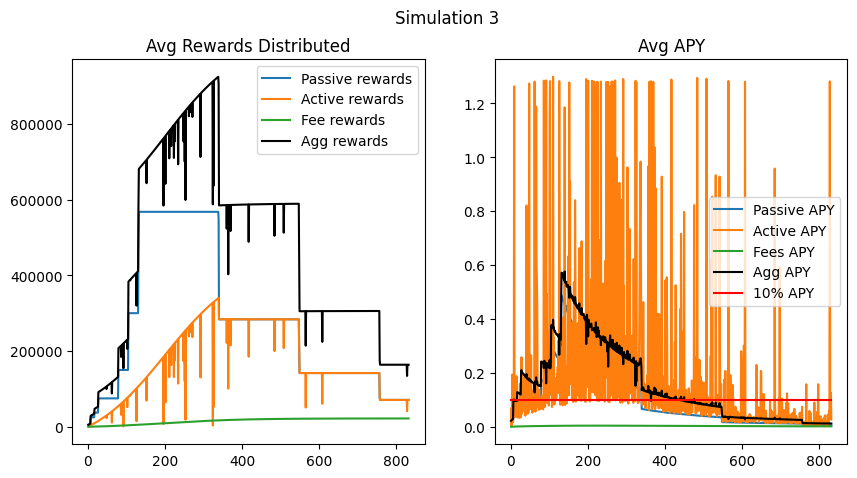

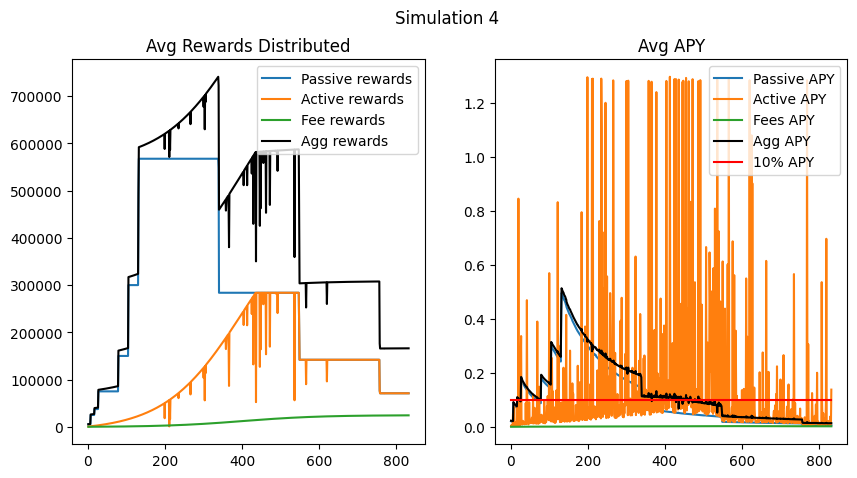

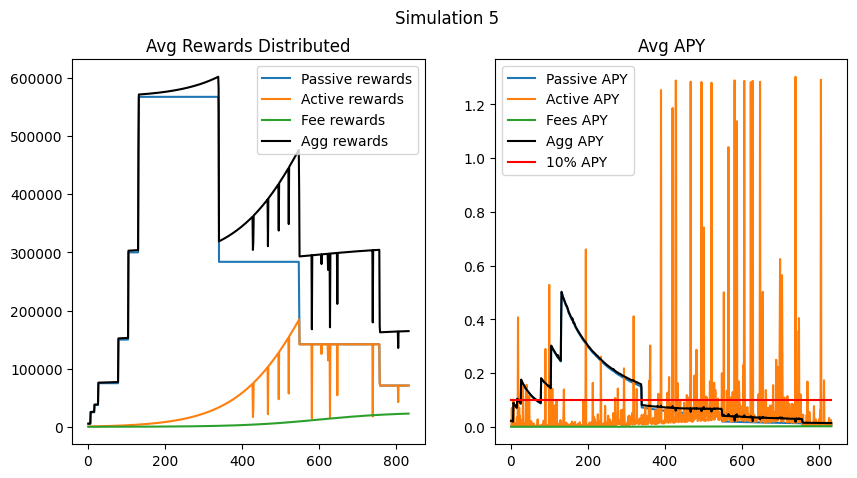

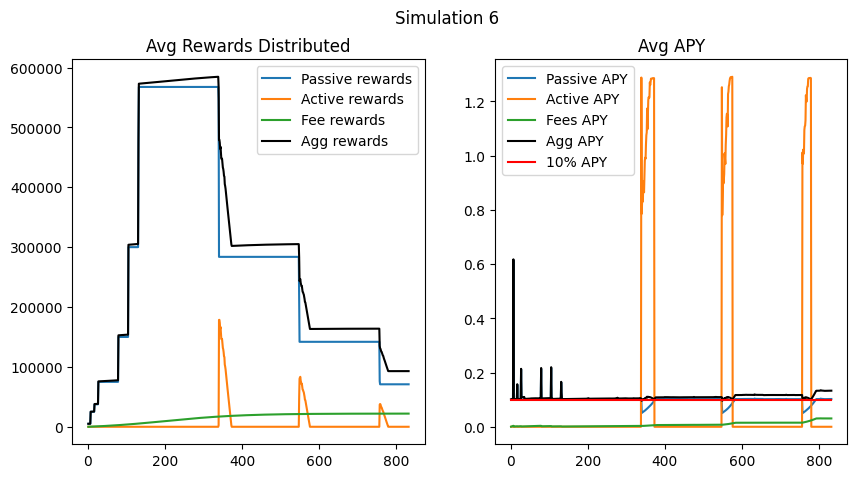

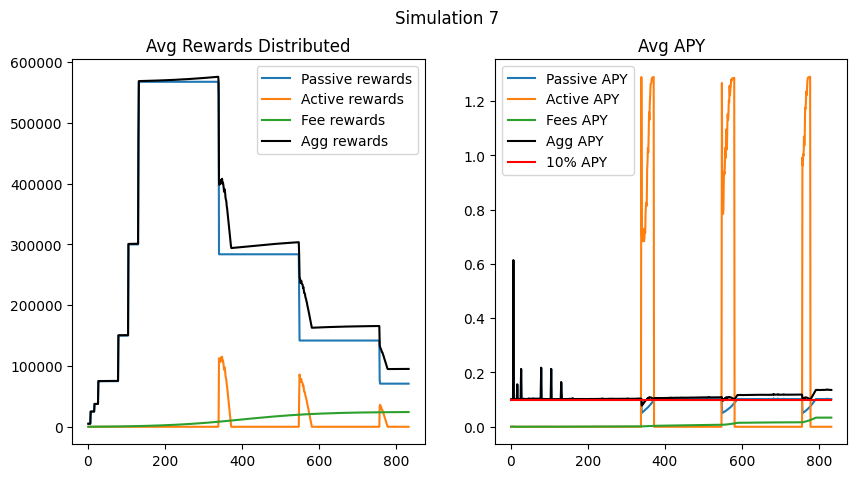

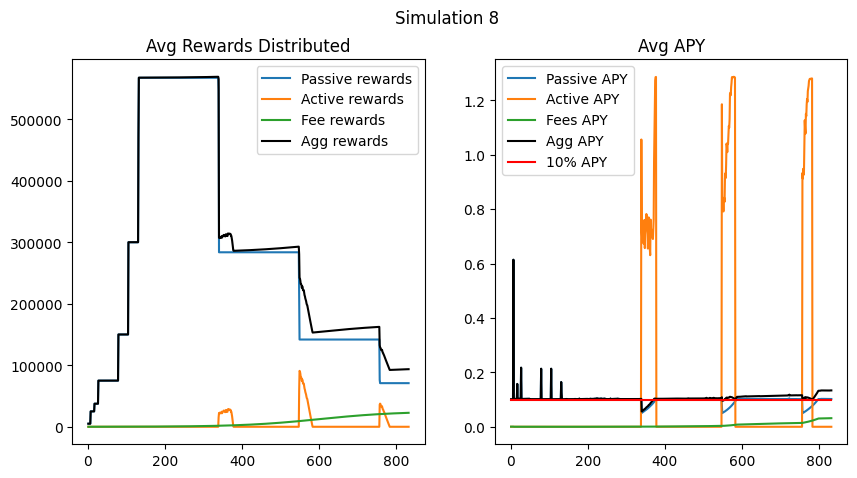

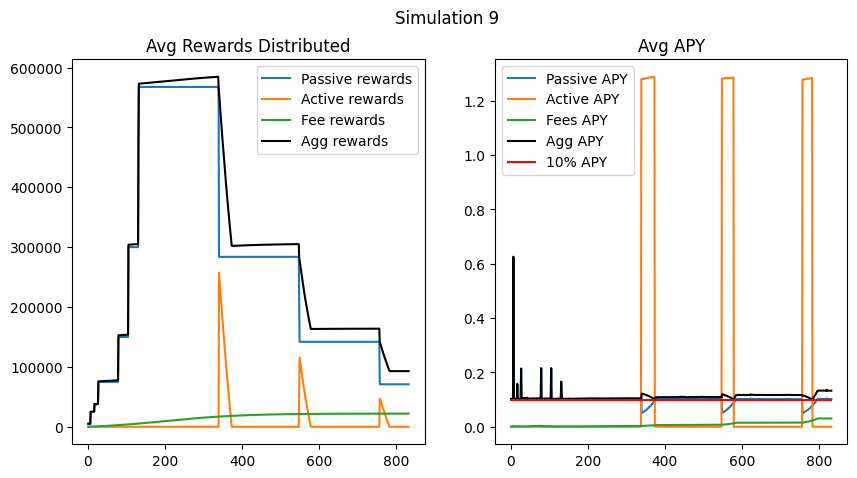

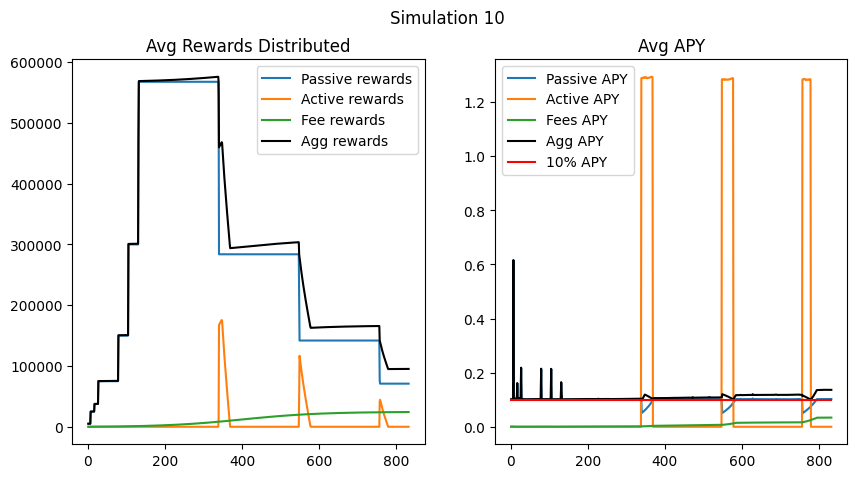

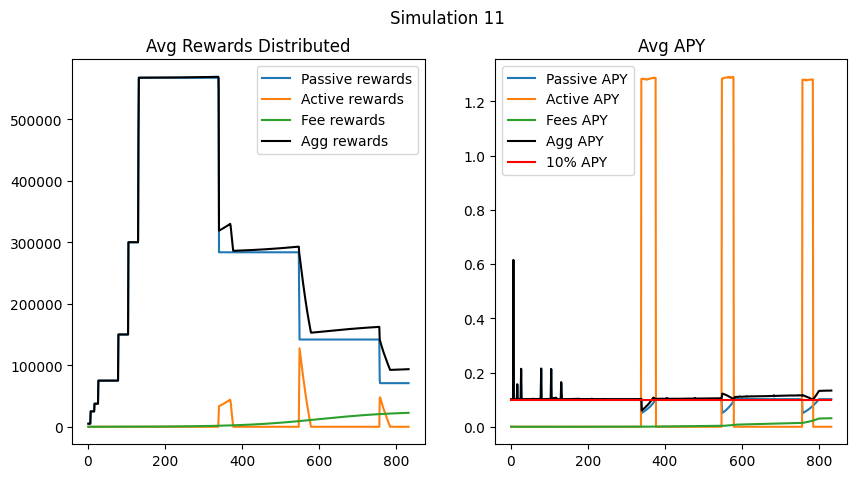

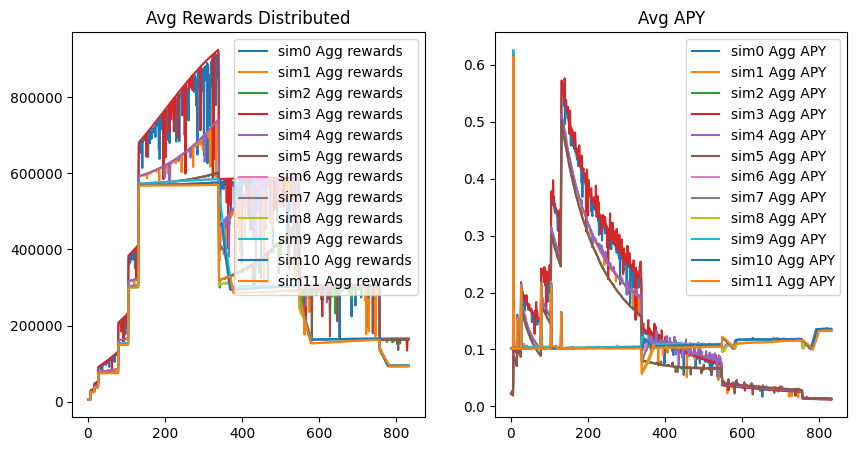

In [20]:
def f(x):
    return x-x+0.1 

weeks = 4

for sim in range(0, max(df_p.simulation) + 1):
    df_tmp = df_avg_apy[df_avg_apy.simulation == sim]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    #ax[0].plot(df_avg_apy.timestep, df_avg_apy.locked_supply, label='Locked Supply')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive, label='Passive rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active, label='Active rewards')
    #ax[0].plot(df_tmp.timestep, get_rolling_avg(df_tmp.rewards_distributed_df_active, weeks), label='1m avg - Active rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees, label='Fee rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.avg_Agg_rewards_distributed, label='Agg rewards', color='black')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Passive_APY, label='Passive APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Active_APY, label='Active APY')
    #ax[1].plot(df_tmp.timestep, get_rolling_avg(df_tmp.avg_Active_APY, weeks), label='1m avg - Active APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Fees_APY, label='Fees APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Agg_APY, label='Agg APY', color='black')
    ax[1].plot(df_tmp.timestep, f(df_tmp.timestep), label='10% APY', color='red')
    ax[0].set_title('Avg Rewards Distributed')
    ax[1].set_title('Avg APY')
    ax[0].legend()
    ax[1].legend()
    fig.suptitle(f"Simulation {sim}")
    plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
for sim in range(0, max(df_p.simulation) + 1):
    df_tmp = df_avg_apy[df_avg_apy.simulation == sim]
    ax[0].plot(df_tmp.timestep, df_tmp.avg_Agg_rewards_distributed, label=f'sim{sim} Agg rewards')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Agg_APY, label=f'sim{sim} Agg APY')
ax[0].set_title('Avg Rewards Distributed')
ax[1].set_title('Avg APY')
ax[0].legend()
ax[1].legend()
plt.show()


In [ ]:
import plotly.graph_objects as go

run = 1
timestep = 300

df_pw = df_p[df_p.run == run]
df_pw = df_pw[df_pw.timestep == timestep]
y_data = [df_pw.ocean_unlocked_supply.iloc[0] + df_pw.locked_supply.iloc[0]
         , -1 * df_pw.ocean_unlocked_supply.iloc[0]
         , -1 * df_pw.locked_supply.iloc[0]
         , df_pw.ve_balance.iloc[0]
         , -1 * df_pw.ve_balance.iloc[0] * df_pw.active_pct.iloc[0]
         , -1 * df_pw.ve_balance.iloc[0] * (1 - df_pw.active_pct.iloc[0])]



fig = go.Figure(go.Waterfall(
    name = "Ocean Supply", orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "relative", "relative"],
    x = ["Circulating Supply", "Unlocked", "Locked", "veBalance", "Active (vote on ranked asset)", "Passive"],
    textposition = "outside",
    #text = ["Circulating Supply", "Unlocked", "Locked", "veBalance", "Active (vote on ranked asset)", "Passive"],
    y = y_data,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = f"Ocean Token Supply Waterfall Chart run {run} timestep {timestep}",
        showlegend = True
)

fig.show()

In [16]:
# vote distributuion Run X, Timestep X
# df_pw.data_assets.iloc[0]

### model verification analysis:
- Treasury decreases according to the distribution schedule
- circulating supply increases according to the distribution schedule
- Locked & Unlocked supply are volatile because of locking behavior & the unlock decay of the ve mechanism (see locked pct), but trend upwards with circulating supply
- Locked pct is not uniform (0-100%) despite that assumption/implementation because the unlock decay takes time and a higher % ends up selected before it can decay much
- ve balance trends upward along with locked supply, but is also influenced by lock duration (which should be uniform random 1 week - 4 years)
- Active pct is uniform random! because voting behavior changes every timestep with no restrictions or time delays
- Passive rewards distributed according to distribution schedule
- active rewards distributed according to the distribution schedule but also depend on locking/voting behavior (i.e. active_pct&asset-level distribution (which is random uniform)). Plus the ceiling (DCV or APY) implemented in the rewards function. Therefore also the DCV growth rate
- Fee rewards distribution depends on DCV growth rate

APYs!
- Passive: volatile because locking behavior influences locked supply. What looks like a lower bound is due to the 85% cap to locked supply which limits the dilution effect
- Active: volatile because locking behavior influences locking supply & voting behavior influences active supply/asset-level distribution. plus there is a ceiling on rewards distributed (DCV*0.1 & 125% APY) implemented in the rewards function
- Fees: volatile because locking behavior influences locked supply.

Conclusion:
- according to this model, this token model will not incentivize locking Ocean enough in the short & long-term. APY is too low initially when it's mainly passive_APY, also even after DCV is no longer a ceiling for Active rewards the APY is still low & decreases further because protocol revenues remain low.

Next-steps:
- Everything in this model is denominated in $Ocean - would considering an external $Ocean price change anything? 
- could improve locking behavior: either change the implementation so that it is actually uniform random (not sure how), or treat it with a starting value & growth rate
    - did this, passive APY is for sure higher, but the "answer"/conclusion of whether it is enough to incentivize locking is still a bit arbitrary
- could improve voting behavior: 1. could assume perfect strategies to get a true ceiling for perspective/reference 2. could be more complete with the analysis by calculating Active_APY for every possible voting outcome and then (assuming every outcome is =likely) create a probability distrobution of active rewards given a certain locked supply (note, this would still depend on locking behavior)
    - did 1.
    - but 2. would not actually be computationally possible


949310.498104578

In [14]:
x = np.arange(0, 800)
y = lambda x: 0.005*((1+0.2*((1-0.05)**x))**x) #exponential increase/decrease

y2_1 = lambda x: (5e7 / (1 + np.exp(-(1/100)*(x - 200)))) - ((5e7 / (1 + np.exp(-(1/100)*(0 - 200)))) - 50000) #sigmoid
y2_2 = lambda x: (5e7 / (1 + np.exp(-(1/100)*(x - 400)))) - ((5e7 / (1 + np.exp(-(1/100)*(0 - 400)))) - 50000) #sigmoid
y2_3 = lambda x: (5e7 / (1 + np.exp(-(1/100)*(x - 600)))) - ((5e7 / (1 + np.exp(-(1/100)*(0 - 600)))) - 50000) #sigmoid

y22 = lambda x: (0.85/0.03)*(0.03 / (1 + np.exp(-(1/100)*(x - 400)))) + 0.03 #sigmoid
y3 = lambda x: 1e6*(1+0.1)**(0.1*x)

y4 = lambda x: (0.85 - 0.03) / 800 * x + 0.03

#f(x) = 5e7 / (1 + np.exp(-(1/100)*(x - 200)))



plt.plot(x,y2_1(x), label='2_1')
plt.plot(x,y2_2(x), label='2_2')
plt.plot(x,y2_3(x), label='2_3')
plt.legend()


50000.0

In [88]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! THIS IS IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#            I think what I'm missing is the APY ceiling constraint.
#            we want to minimize active_supply
#                - such that:
#                    - active_APY =125% ;; ((1+active_rewards/active_supply)**52 - 1) = 125% (we don't want it to be less than that because that would mean we are diluting the available active rewards/have activated many locked tokens, and we are "lazy"!. it can't be greater than that because of the ceiling in the rewards function)
#                       - active_rewards = 1.25 + 1 ^ (1/52) - 1 * active_supply
#                    - active rewards <= DCV ceiling (we can't receive more rewards than the DCV ceiling, but we might want to receive less IF we can already capture enough incremental active rewards at 125% APY without activating too many locked tokens because we are "lazy"!
#                    - active rewards <= distro_schedule ceiling (same as above)
#                    - passive APY + fees APY + active_APY(i.e.125%)*(active_supply/locked_supply) <= min_apy (the reason we're here in the first place is because passive_apy+fees_apy < min_apy, then every locked token that we activate earns (assuming perfect voting strategy) 125% APY and therefore increases our aggregate APY. we should activate locked tokens until we capture enough active rewards to bring agg_apy back to min_apy. if we hit the ceilings, however, we would not reach min_apy)
#                        - 

# is it double? we want to minimize the active rewards st. agg_apy = min_apy... (this might not be right. I think I can do it only with the points above)
# potentially two loops??

# or... maximize active_supply st. 0 <= min_apy-passive_apy-fees_apy-active_apy*(active_supply/locked_supply) (i.e. activate locked_supply until we hit min_apy)
#                              st. DCV ceiling (i.e. ????????????????)
#                              st. distro_schedule ceiling
#                              where active_apy = 0.015717

import scipy

min_apy = 0.1
min_weekly_yield = (min_apy + 1)**(1/52)-1
passive_apy = 0.03
passive_weekly_yield = (passive_apy + 1)**(1/52)-1
fees_apy = 0.001
fees_weekly_yield = (fees_apy + 1)**(1/52)-1
cap_weekly_yield = 0.015717
locked_supply = 5e8
dcv_ceiling = 1.5e7
distro_ceiling = 3e5

# if the function returns a value greater than or = to 0, it is considered a valid solution


def cost(active_supply): #cost
    return -active_supply
def constraint1(active_supply, m = min_weekly_yield, p = passive_weekly_yield, f = fees_weekly_yield, c = cap_weekly_yield, l = locked_supply): #ineq
    return m - p - f - c*active_supply/l
def constraint2(active_supply, l = locked_supply): #ineq
    return l - active_supply
def constraint3(active_supply, d = dcv_ceiling, c = cap_weekly_yield): #ineq
    return d / c - active_supply
def constraint4(active_supply, di = distro_ceiling, c = cap_weekly_yield): #ineq
    return di / c - active_supply

def constraint_zero(x):
    return x-x

all_constraints = [{'type':'ineq', 'fun': constraint1}
                   , {'type':'ineq', 'fun': constraint2}
                   , {'type':'ineq', 'fun': constraint3}
                   , {'type':'ineq', 'fun': constraint4}]

In [89]:
out = scipy.optimize.minimize(cost, 0, constraints=all_constraints)
active_supply = out.x[0]
active_supply

19087612.139721323

In [85]:
x = 19082000
print(cost(x))
print(constraint1(x))
print(constraint2(x))
print(constraint3(x))
print(constraint4(x))

-19082000
0.0006469238098250432
480918000.0
935298606.9860661
5612.139721322805


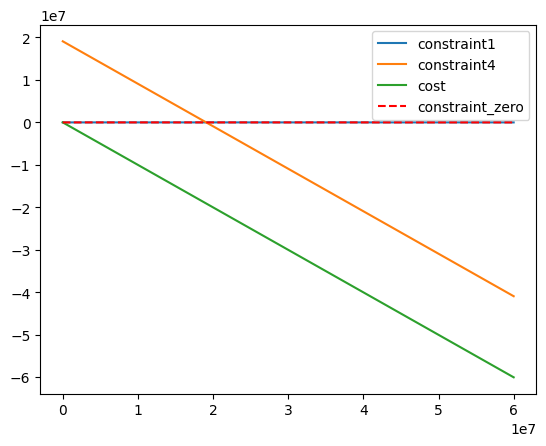

In [66]:
x = np.arange(0, locked_supply, locked_supply/10000)
x = np.arange(0, 60000000,1000)
plt.plot(x, constraint1(x), label='constraint1')
# satisfied plt.plot(x, constraint2(x), label='constraint2')
# satisfied plt.plot(x, constraint3(x), label='constraint3')
plt.plot(x, constraint4(x), label='constraint4')
plt.plot(x, cost(x), label='cost')
plt.plot(x, constraint_zero(x), label='constraint_zero', color='red', linestyle='--')
plt.legend()
plt.show()

In [7]:
agents_data_asset = {}
for i in range(100):
    agent = dataasset(
                          id=uuid.uuid4(),
                          dataconsumevolume=0.0
                         )
    agents_data_asset[str(agent.id)] = agent

dcv = 50000
assets_consumed = {}
for asset in agents_data_asset.keys():
    assets_consumed[asset] = np.random.uniform(0.0,1.0)
total_consumed = sum(assets_consumed.values())
for asset in agents_data_asset.keys():
    assets_consumed[asset] = assets_consumed[asset]/total_consumed*dcv

for asset in agents_data_asset.keys():
    agents_data_asset[asset].dataconsumevolume = assets_consumed[asset]

In [8]:
data_assets = np.array([])
dcv_rewards_period = np.array([])
for asset in agents_data_asset:
    # to make ranking process simple, we need two identical arrays: one with data_assets, one with the corresponding DCV
    data_assets = np.append(data_assets, asset)
    dcv_rewards_period = np.append(dcv_rewards_period, agents_data_asset[asset].dataconsumevolume)
ranks = scipy.stats.rankdata(-1 * dcv_rewards_period, method='min')
ranks
# Rank j - pct_j
allocations = np.zeros_like(ranks)
allocations = allocations.astype(float)
top_indicies = np.where(ranks <= 100)
logranks = np.log10(ranks)
allocations[top_indicies] = max(logranks[top_indicies]) - logranks[top_indicies] + np.log10(1.5)
allocations_normalized = allocations / np.sum(allocations) * 0.8338763045905532

sum(allocations_normalized)

0.8338763045905534